
Accuracy by Scenario:

Accuracy for FT_No_Context:
  Scenario: Order Analysis, Accuracy: 70.00%
  Scenario: Supplier Analysis, Accuracy: 78.95%
  Scenario: Shipping Analysis, Accuracy: 84.21%
  Scenario: Inventory Management, Accuracy: 84.21%
  Scenario: Product Analysis, Accuracy: 84.21%
  Scenario: Customer Analysis, Accuracy: 73.68%
  Scenario: cross_scenario, Accuracy: 65.00%
  Scenario: Employee Performance, Accuracy: 63.16%
  Overall Accuracy: 75.32%

Accuracy for FT_With_Context:
  Scenario: Order Analysis, Accuracy: 85.00%
  Scenario: Supplier Analysis, Accuracy: 73.68%
  Scenario: Shipping Analysis, Accuracy: 84.21%
  Scenario: Inventory Management, Accuracy: 78.95%
  Scenario: Product Analysis, Accuracy: 89.47%
  Scenario: Customer Analysis, Accuracy: 73.68%
  Scenario: cross_scenario, Accuracy: 80.00%
  Scenario: Employee Performance, Accuracy: 73.68%
  Overall Accuracy: 79.87%

Accuracy for Base_With_Context:
  Scenario: Order Analysis, Accuracy: 80.00%
  Scenario: Supplie

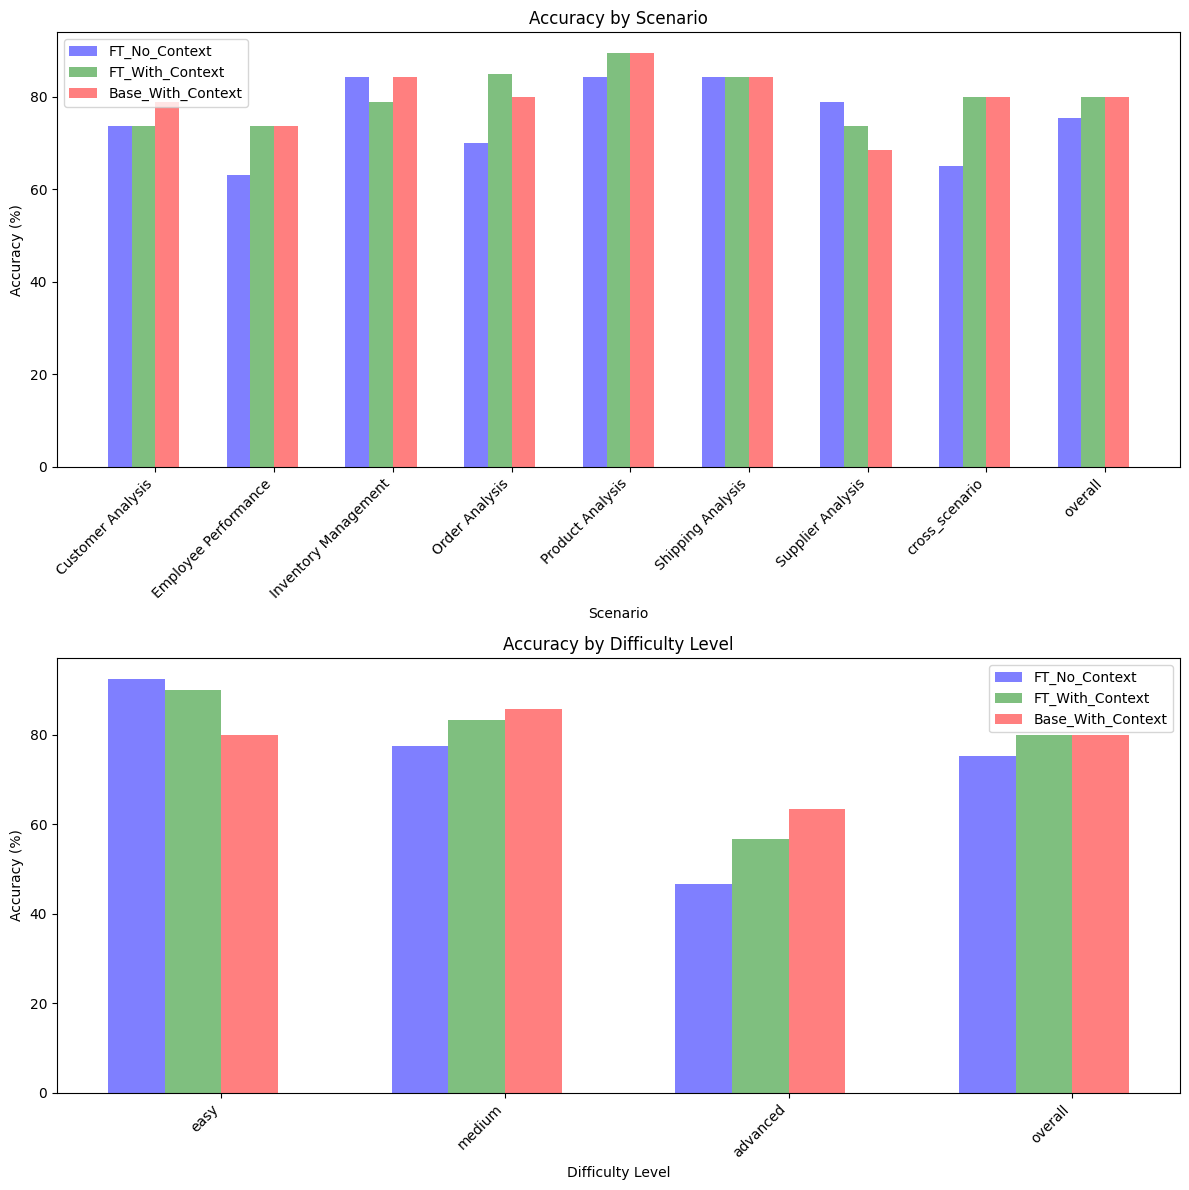

In [4]:
import os  
import json  
import matplotlib.pyplot as plt  
from pathlib import Path  
from dotenv import load_dotenv  
from openai import AzureOpenAI  
from collections import defaultdict  
from concurrent.futures import ThreadPoolExecutor  

# Load environment variables  
env_path = Path('.') / 'secrets.env'  
load_dotenv(dotenv_path=env_path)  
  
openaikey = os.getenv("AZURE_OPENAI_API_KEY")  
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")  
openaikey_base = os.getenv("AZURE_OPENAI_API_KEY_BASE")  
openaiservice_base = os.getenv("AZURE_OPENAI_ENDPOINT_BASE")  
  
# Initialize OpenAI client  
client = AzureOpenAI(api_key=openaikey, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice)  
client_base = AzureOpenAI(api_key=openaikey_base, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice_base)  
  
# Load the test dataset  
with open("../data/test_data_v2.json", "r") as file:  
    test_data = json.load(file)  
# Load the schema information  
with open("../data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
schema = json.dumps(ontology, indent=4)  
  
# Function to generate SQL queries using the first OpenAI model without context  
def generate_sql_query_no_context(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT2"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": "You are querying the MDDX database, what is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the first OpenAI model with context  
def generate_sql_query_with_context(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT2"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database. Use the following schema information\n: {schema}. \nWhat is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the base OpenAI model with context  
def generate_sql_query_base_model_with_context(question):  
    response = client_base.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_BASE_DEPLOYMENT"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database. Use the following schema: {schema}. What is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
  
# Function to evaluate SQL queries using the second OpenAI model  
def evaluate_sql_query(question, generated_query, ground_truth_query):  
    user_message = f"""  
    You are a SQL expert. Given the following user question, generated SQL query, and the ground truth SQL query, evaluate whether the generated SQL query would correctly answer the user's question. The generated query does not have to be identical to the ground truth query.  
    ## User Question  
    {question}  
    ## Generated SQL Query  
    {generated_query}  
    ## Ground Truth SQL Query  
    {ground_truth_query}  
    Output format: Provide a single word answer as 'yes' or 'no'.  
    Your output:  
    """  
      
    def get_response():  
        response = client.chat.completions.create(  
            model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  # engine = "deployment_name".  
            messages=[  
                {"role": "system", "content": "You are a SQL expert"},  
                {"role": "user", "content": user_message},  
            ],  
            timeout=90,  
        )  
        return response.choices[0].message.content.strip().lower()  
      
    with ThreadPoolExecutor(max_workers=3) as executor:  
        votes = list(executor.map(lambda _: get_response(), range(5)))  
      
    # Take the majority vote  
    return 'yes' if votes.count('yes') > votes.count('no') else 'no'  
  
# Initialize dictionaries to store evaluation results  
results_by_setup = {  
    "FT_No_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "FT_With_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "Base_With_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
}  
  
# Generate SQL queries and evaluate them  
for item in test_data:  
    scenario = item["scenario"]  
    difficulty = item["difficulty"]  
    question = item["input"]  
    ground_truth_query = item["output"]  
  
    # Merge "hard" with "advanced"  
    if difficulty == "hard":  
        difficulty = "advanced"  
  
    # Generate SQL query using the first model without context  
    generated_query_no_context = generate_sql_query_no_context(question)  
  
    # Generate SQL query using the first model with context  
    generated_query_with_context_ft = generate_sql_query_with_context(question)  
  
    # Generate SQL query using the base model with context  
    generated_query_with_context_base = generate_sql_query_base_model_with_context(question)  
  
    # Evaluate the generated queries using the second model  
    evaluation_result_no_context = evaluate_sql_query(question, generated_query_no_context, ground_truth_query)  
    evaluation_result_with_context_ft = evaluate_sql_query(question, generated_query_with_context_ft, ground_truth_query)  
    evaluation_result_with_context_base = evaluate_sql_query(question, generated_query_with_context_base, ground_truth_query)  
  
    # Update results for no context  
    results_by_setup["FT_No_Context"][scenario]["total"] += 1  
    results_by_setup["FT_No_Context"][difficulty]["total"] += 1  
    if evaluation_result_no_context == 'yes':  
        results_by_setup["FT_No_Context"][scenario]["correct"] += 1  
        results_by_setup["FT_No_Context"][difficulty]["correct"] += 1  
  
    # Update results for context with fine-tuned model  
    results_by_setup["FT_With_Context"][scenario]["total"] += 1  
    results_by_setup["FT_With_Context"][difficulty]["total"] += 1  
    if evaluation_result_with_context_ft == 'yes':  
        results_by_setup["FT_With_Context"][scenario]["correct"] += 1  
        results_by_setup["FT_With_Context"][difficulty]["correct"] += 1  
  
    # Update results for context with base model  
    results_by_setup["Base_With_Context"][scenario]["total"] += 1  
    results_by_setup["Base_With_Context"][difficulty]["total"] += 1  
    if evaluation_result_with_context_base == 'yes':  
        results_by_setup["Base_With_Context"][scenario]["correct"] += 1  
        results_by_setup["Base_With_Context"][difficulty]["correct"] += 1  
  
# Calculate and print accuracy by scenario for each setup  
print("\nAccuracy by Scenario:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for scenario, counts in setup_results.items():  
        if scenario in ["easy", "medium", "advanced"]:  
            continue  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Scenario: {scenario}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Calculate and print accuracy by difficulty for each setup  
print("\nAccuracy by Difficulty Level:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for difficulty in ["easy", "medium", "advanced"]:  
        counts = setup_results[difficulty]  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Difficulty: {difficulty}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Visualize accuracy by scenario for each setup  
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))  
  
# Prepare data for plotting  
scenario_names = sorted(set(s for s in results_by_setup["FT_No_Context"] if s not in ["easy", "medium", "advanced"]))  
difficulty_levels = ["easy", "medium", "advanced"]  
all_scenarios = scenario_names + ["overall"]  
all_difficulties = difficulty_levels + ["overall"]  
  
# Calculate overall accuracies  
for setup_name, setup_results in results_by_setup.items():  
    overall_correct = sum(setup_results[s]["correct"] for s in scenario_names)  
    overall_total = sum(setup_results[s]["total"] for s in scenario_names)  
    setup_results["overall_scenario"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
    overall_correct = sum(setup_results[d]["correct"] for d in difficulty_levels)  
    overall_total = sum(setup_results[d]["total"] for d in difficulty_levels)  
    setup_results["overall_difficulty"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
  
# Plot accuracy by scenario  
width = 0.2  
x_scenario = range(len(all_scenarios))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green', 'red'])):  
    scenario_accuracies = [(results_by_setup[setup_name][s]["correct"] / results_by_setup[setup_name][s]["total"]) * 100 if results_by_setup[setup_name][s]["total"] > 0 else 0 for s in scenario_names] + [  
        (results_by_setup[setup_name]["overall_scenario"]["correct"] / results_by_setup[setup_name]["overall_scenario"]["total"]) * 100 if results_by_setup[setup_name]["overall_scenario"]["total"] > 0 else 0]  
    axes[0].bar([p + idx * width for p in x_scenario], scenario_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[0].set_title('Accuracy by Scenario')  
axes[0].set_xlabel('Scenario')  
axes[0].set_ylabel('Accuracy (%)')  
axes[0].set_xticks([p + 1.5 * width for p in x_scenario])  
axes[0].set_xticklabels(all_scenarios, rotation=45, ha='right')  
axes[0].legend()  
  
# Plot accuracy by difficulty  
x_difficulty = range(len(all_difficulties))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green', 'red'])):  
    difficulty_accuracies = [(results_by_setup[setup_name][d]["correct"] / results_by_setup[setup_name][d]["total"]) * 100 if results_by_setup[setup_name][d]["total"] > 0 else 0 for d in difficulty_levels] + [  
        (results_by_setup[setup_name]["overall_difficulty"]["correct"] / results_by_setup[setup_name]["overall_difficulty"]["total"]) * 100 if results_by_setup[setup_name]["overall_difficulty"]["total"] > 0 else 0]  
    axes[1].bar([p + idx * width for p in x_difficulty], difficulty_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[1].set_title('Accuracy by Difficulty Level')  
axes[1].set_xlabel('Difficulty Level')  
axes[1].set_ylabel('Accuracy (%)')  
axes[1].set_xticks([p + 1.5 * width for p in x_difficulty])  
axes[1].set_xticklabels(all_difficulties, rotation=45, ha='right')  
axes[1].legend()  
  
plt.tight_layout()  
plt.show()  


V1 evaluation


Accuracy by Scenario:

Accuracy for FT_No_Context:
  Scenario: Supplier Analysis, Accuracy: 47.37%
  Scenario: cross_scenario, Accuracy: 15.00%
  Scenario: Customer Analysis, Accuracy: 51.35%
  Scenario: Inventory Management, Accuracy: 51.28%
  Scenario: Employee Performance, Accuracy: 33.33%
  Scenario: Order Analysis, Accuracy: 51.28%
  Scenario: Product Analysis, Accuracy: 56.76%
  Scenario: Shipping Analysis, Accuracy: 73.68%
  Overall Accuracy: 49.48%

Accuracy for FT_With_Context:
  Scenario: Supplier Analysis, Accuracy: 60.53%
  Scenario: cross_scenario, Accuracy: 50.00%
  Scenario: Customer Analysis, Accuracy: 64.86%
  Scenario: Inventory Management, Accuracy: 66.67%
  Scenario: Employee Performance, Accuracy: 66.67%
  Scenario: Order Analysis, Accuracy: 76.92%
  Scenario: Product Analysis, Accuracy: 54.05%
  Scenario: Shipping Analysis, Accuracy: 86.84%
  Overall Accuracy: 66.90%

Accuracy for Base_With_Context:
  Scenario: Supplier Analysis, Accuracy: 73.68%
  Scenario: cros

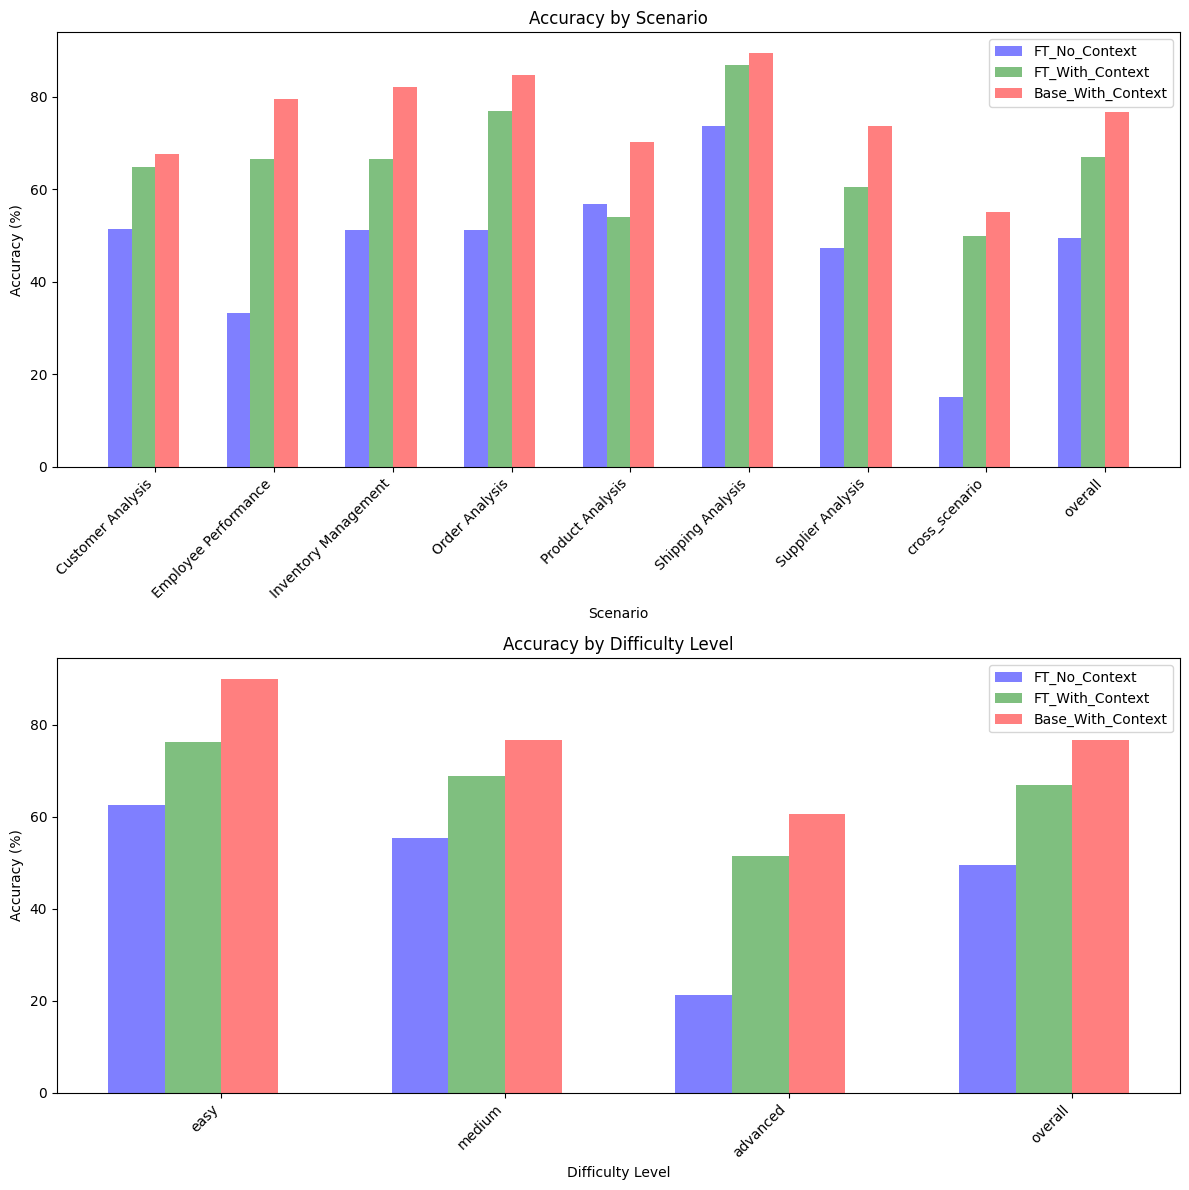

In [6]:
import os  
import json  
import matplotlib.pyplot as plt  
from pathlib import Path  
from dotenv import load_dotenv  
from openai import AzureOpenAI  
from collections import defaultdict  
from concurrent.futures import ThreadPoolExecutor  

# Load environment variables  
env_path = Path('.') / 'secrets.env'  
load_dotenv(dotenv_path=env_path)  
  
openaikey = os.getenv("AZURE_OPENAI_API_KEY")  
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")  
openaikey_base = os.getenv("AZURE_OPENAI_API_KEY_BASE")  
openaiservice_base = os.getenv("AZURE_OPENAI_ENDPOINT_BASE")  
  
# Initialize OpenAI client  
client = AzureOpenAI(api_key=openaikey, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice)  
client_base = AzureOpenAI(api_key=openaikey_base, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice_base)  
  
# Load the test dataset  
with open("../data/test_data_v2.json", "r") as file:  
    test_data = json.load(file)  
# Load the schema information  
with open("../data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
schema = json.dumps(ontology, indent=4)  
  
# Function to generate SQL queries using the first OpenAI model without context  
def generate_sql_query_no_context(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT1"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": "You are querying the MDDX database, what is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the first OpenAI model with context  
def generate_sql_query_with_context(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT1"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database. Use the following schema information\n: {schema}. \nWhat is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the base OpenAI model with context  
def generate_sql_query_base_model_with_context(question):  
    response = client_base.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_BASE_DEPLOYMENT"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database. Use the following schema: {schema}. What is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
  
# Function to evaluate SQL queries using the second OpenAI model  
def evaluate_sql_query(question, generated_query, ground_truth_query):  
    user_message = f"""  
    You are a SQL expert. Given the following user question, generated SQL query, and the ground truth SQL query, evaluate whether the generated SQL query would correctly answer the user's question. The generated query does not have to be identical to the ground truth query.  
    ## User Question  
    {question}  
    ## Generated SQL Query  
    {generated_query}  
    ## Ground Truth SQL Query  
    {ground_truth_query}  
    Output format: Provide a single word answer as 'yes' or 'no'.  
    Your output:  
    """  
      
    def get_response():  
        response = client.chat.completions.create(  
            model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  # engine = "deployment_name".  
            messages=[  
                {"role": "system", "content": "You are a SQL expert"},  
                {"role": "user", "content": user_message},  
            ],  
            timeout=90,  
        )  
        return response.choices[0].message.content.strip().lower()  
      
    with ThreadPoolExecutor(max_workers=3) as executor:  
        votes = list(executor.map(lambda _: get_response(), range(5)))  
      
    # Take the majority vote  
    return 'yes' if votes.count('yes') > votes.count('no') else 'no'  
  
# Initialize dictionaries to store evaluation results  
results_by_setup = {  
    "FT_No_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "FT_With_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "Base_With_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
}  
  
# Generate SQL queries and evaluate them  
for item in test_data:  
    scenario = item["scenario"]  
    difficulty = item["difficulty"]  
    question = item["input"]  
    ground_truth_query = item["output"]  
  
    # Merge "hard" with "advanced"  
    if difficulty == "hard":  
        difficulty = "advanced"  
  
    # Generate SQL query using the first model without context  
    generated_query_no_context = generate_sql_query_no_context(question)  
  
    # Generate SQL query using the first model with context  
    generated_query_with_context_ft = generate_sql_query_with_context(question)  
  
    # Generate SQL query using the base model with context  
    generated_query_with_context_base = generate_sql_query_base_model_with_context(question)  
  
    # Evaluate the generated queries using the second model  
    evaluation_result_no_context = evaluate_sql_query(question, generated_query_no_context, ground_truth_query)  
    evaluation_result_with_context_ft = evaluate_sql_query(question, generated_query_with_context_ft, ground_truth_query)  
    evaluation_result_with_context_base = evaluate_sql_query(question, generated_query_with_context_base, ground_truth_query)  
  
    # Update results for no context  
    results_by_setup["FT_No_Context"][scenario]["total"] += 1  
    results_by_setup["FT_No_Context"][difficulty]["total"] += 1  
    if evaluation_result_no_context == 'yes':  
        results_by_setup["FT_No_Context"][scenario]["correct"] += 1  
        results_by_setup["FT_No_Context"][difficulty]["correct"] += 1  
  
    # Update results for context with fine-tuned model  
    results_by_setup["FT_With_Context"][scenario]["total"] += 1  
    results_by_setup["FT_With_Context"][difficulty]["total"] += 1  
    if evaluation_result_with_context_ft == 'yes':  
        results_by_setup["FT_With_Context"][scenario]["correct"] += 1  
        results_by_setup["FT_With_Context"][difficulty]["correct"] += 1  
  
    # Update results for context with base model  
    results_by_setup["Base_With_Context"][scenario]["total"] += 1  
    results_by_setup["Base_With_Context"][difficulty]["total"] += 1  
    if evaluation_result_with_context_base == 'yes':  
        results_by_setup["Base_With_Context"][scenario]["correct"] += 1  
        results_by_setup["Base_With_Context"][difficulty]["correct"] += 1  
  
# Calculate and print accuracy by scenario for each setup  
print("\nAccuracy by Scenario:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for scenario, counts in setup_results.items():  
        if scenario in ["easy", "medium", "advanced"]:  
            continue  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Scenario: {scenario}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Calculate and print accuracy by difficulty for each setup  
print("\nAccuracy by Difficulty Level:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for difficulty in ["easy", "medium", "advanced"]:  
        counts = setup_results[difficulty]  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Difficulty: {difficulty}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Visualize accuracy by scenario for each setup  
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))  
  
# Prepare data for plotting  
scenario_names = sorted(set(s for s in results_by_setup["FT_No_Context"] if s not in ["easy", "medium", "advanced"]))  
difficulty_levels = ["easy", "medium", "advanced"]  
all_scenarios = scenario_names + ["overall"]  
all_difficulties = difficulty_levels + ["overall"]  
  
# Calculate overall accuracies  
for setup_name, setup_results in results_by_setup.items():  
    overall_correct = sum(setup_results[s]["correct"] for s in scenario_names)  
    overall_total = sum(setup_results[s]["total"] for s in scenario_names)  
    setup_results["overall_scenario"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
    overall_correct = sum(setup_results[d]["correct"] for d in difficulty_levels)  
    overall_total = sum(setup_results[d]["total"] for d in difficulty_levels)  
    setup_results["overall_difficulty"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
  
# Plot accuracy by scenario  
width = 0.2  
x_scenario = range(len(all_scenarios))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green', 'red'])):  
    scenario_accuracies = [(results_by_setup[setup_name][s]["correct"] / results_by_setup[setup_name][s]["total"]) * 100 if results_by_setup[setup_name][s]["total"] > 0 else 0 for s in scenario_names] + [  
        (results_by_setup[setup_name]["overall_scenario"]["correct"] / results_by_setup[setup_name]["overall_scenario"]["total"]) * 100 if results_by_setup[setup_name]["overall_scenario"]["total"] > 0 else 0]  
    axes[0].bar([p + idx * width for p in x_scenario], scenario_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[0].set_title('Accuracy by Scenario')  
axes[0].set_xlabel('Scenario')  
axes[0].set_ylabel('Accuracy (%)')  
axes[0].set_xticks([p + 1.5 * width for p in x_scenario])  
axes[0].set_xticklabels(all_scenarios, rotation=45, ha='right')  
axes[0].legend()  
  
# Plot accuracy by difficulty  
x_difficulty = range(len(all_difficulties))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green', 'red'])):  
    difficulty_accuracies = [(results_by_setup[setup_name][d]["correct"] / results_by_setup[setup_name][d]["total"]) * 100 if results_by_setup[setup_name][d]["total"] > 0 else 0 for d in difficulty_levels] + [  
        (results_by_setup[setup_name]["overall_difficulty"]["correct"] / results_by_setup[setup_name]["overall_difficulty"]["total"]) * 100 if results_by_setup[setup_name]["overall_difficulty"]["total"] > 0 else 0]  
    axes[1].bar([p + idx * width for p in x_difficulty], difficulty_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[1].set_title('Accuracy by Difficulty Level')  
axes[1].set_xlabel('Difficulty Level')  
axes[1].set_ylabel('Accuracy (%)')  
axes[1].set_xticks([p + 1.5 * width for p in x_difficulty])  
axes[1].set_xticklabels(all_difficulties, rotation=45, ha='right')  
axes[1].legend()  
  
plt.tight_layout()  
plt.show()  

V2 evaluation


Accuracy by Scenario:

Accuracy for FT_No_Context:
  Scenario: Supplier Analysis, Accuracy: 57.89%
  Scenario: cross_scenario, Accuracy: 45.00%
  Scenario: Customer Analysis, Accuracy: 72.97%
  Scenario: Inventory Management, Accuracy: 69.23%
  Scenario: Employee Performance, Accuracy: 69.23%
  Scenario: Order Analysis, Accuracy: 79.49%
  Scenario: Product Analysis, Accuracy: 54.05%
  Scenario: Shipping Analysis, Accuracy: 89.47%
  Overall Accuracy: 68.64%

Accuracy for FT_With_Context:
  Scenario: Supplier Analysis, Accuracy: 55.26%
  Scenario: cross_scenario, Accuracy: 45.00%
  Scenario: Customer Analysis, Accuracy: 70.27%
  Scenario: Inventory Management, Accuracy: 64.10%
  Scenario: Employee Performance, Accuracy: 61.54%
  Scenario: Order Analysis, Accuracy: 84.62%
  Scenario: Product Analysis, Accuracy: 56.76%
  Scenario: Shipping Analysis, Accuracy: 86.84%
  Overall Accuracy: 66.90%

Accuracy for Base_With_Context:
  Scenario: Supplier Analysis, Accuracy: 73.68%
  Scenario: cros

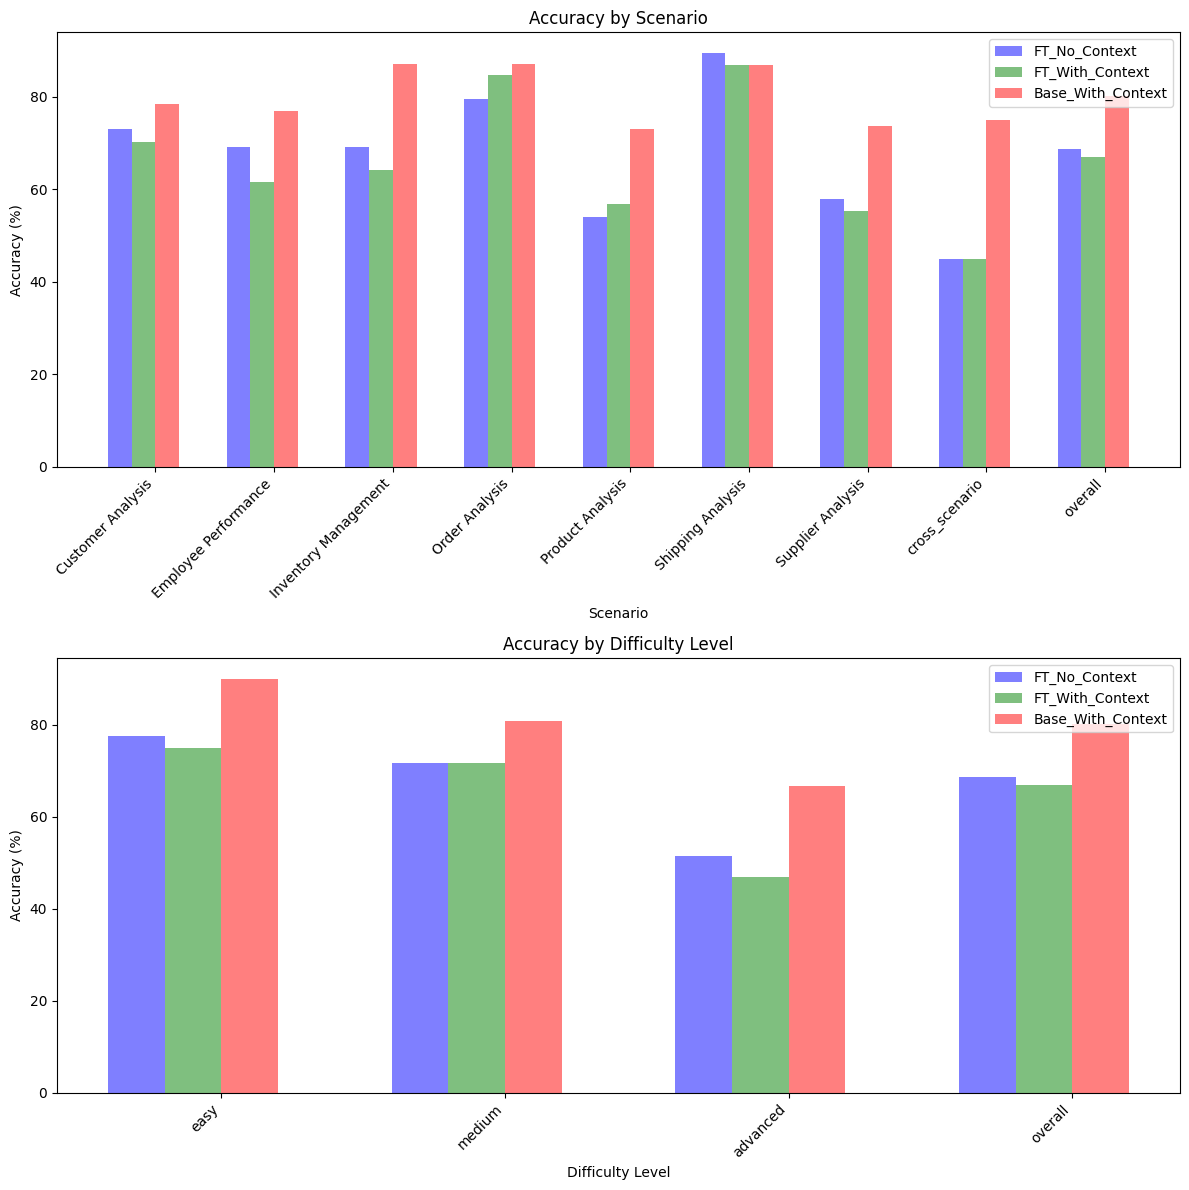

In [5]:
import os  
import json  
import matplotlib.pyplot as plt  
from pathlib import Path  
from dotenv import load_dotenv  
from openai import AzureOpenAI  
from collections import defaultdict  
from concurrent.futures import ThreadPoolExecutor  

# Load environment variables  
env_path = Path('.') / 'secrets.env'  
load_dotenv(dotenv_path=env_path)  
  
openaikey = os.getenv("AZURE_OPENAI_API_KEY")  
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")  
openaikey_base = os.getenv("AZURE_OPENAI_API_KEY_BASE")  
openaiservice_base = os.getenv("AZURE_OPENAI_ENDPOINT_BASE")  
  
# Initialize OpenAI client  
client = AzureOpenAI(api_key=openaikey, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice)  
client_base = AzureOpenAI(api_key=openaikey_base, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice_base)  
  
# Load the test dataset  
with open("../data/test_data_v2.json", "r") as file:  
    test_data = json.load(file)  
# Load the schema information  
with open("../data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
schema = json.dumps(ontology, indent=4)  
  
# Function to generate SQL queries using the first OpenAI model without context  
def generate_sql_query_no_context(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT2"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": "You are querying the MDDX database, what is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the first OpenAI model with context  
def generate_sql_query_with_context(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT2"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database. Use the following schema information\n: {schema}. \nWhat is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the base OpenAI model with context  
def generate_sql_query_base_model_with_context(question):  
    response = client_base.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_BASE_DEPLOYMENT"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database. Use the following schema: {schema}. What is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
  
# Function to evaluate SQL queries using the second OpenAI model  
def evaluate_sql_query(question, generated_query, ground_truth_query):  
    user_message = f"""  
    You are a SQL expert. Given the following user question, generated SQL query, and the ground truth SQL query, evaluate whether the generated SQL query would correctly answer the user's question. The generated query does not have to be identical to the ground truth query.  
    ## User Question  
    {question}  
    ## Generated SQL Query  
    {generated_query}  
    ## Ground Truth SQL Query  
    {ground_truth_query}  
    Output format: Provide a single word answer as 'yes' or 'no'.  
    Your output:  
    """  
      
    def get_response():  
        response = client.chat.completions.create(  
            model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  # engine = "deployment_name".  
            messages=[  
                {"role": "system", "content": "You are a SQL expert"},  
                {"role": "user", "content": user_message},  
            ],  
            timeout=90,  
        )  
        return response.choices[0].message.content.strip().lower()  
      
    with ThreadPoolExecutor(max_workers=3) as executor:  
        votes = list(executor.map(lambda _: get_response(), range(5)))  
      
    # Take the majority vote  
    return 'yes' if votes.count('yes') > votes.count('no') else 'no'  
  
# Initialize dictionaries to store evaluation results  
results_by_setup = {  
    "FT_No_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "FT_With_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "Base_With_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
}  
  
# Generate SQL queries and evaluate them  
for item in test_data:  
    scenario = item["scenario"]  
    difficulty = item["difficulty"]  
    question = item["input"]  
    ground_truth_query = item["output"]  
  
    # Merge "hard" with "advanced"  
    if difficulty == "hard":  
        difficulty = "advanced"  
  
    # Generate SQL query using the first model without context  
    generated_query_no_context = generate_sql_query_no_context(question)  
  
    # Generate SQL query using the first model with context  
    generated_query_with_context_ft = generate_sql_query_with_context(question)  
  
    # Generate SQL query using the base model with context  
    generated_query_with_context_base = generate_sql_query_base_model_with_context(question)  
  
    # Evaluate the generated queries using the second model  
    evaluation_result_no_context = evaluate_sql_query(question, generated_query_no_context, ground_truth_query)  
    evaluation_result_with_context_ft = evaluate_sql_query(question, generated_query_with_context_ft, ground_truth_query)  
    evaluation_result_with_context_base = evaluate_sql_query(question, generated_query_with_context_base, ground_truth_query)  
  
    # Update results for no context  
    results_by_setup["FT_No_Context"][scenario]["total"] += 1  
    results_by_setup["FT_No_Context"][difficulty]["total"] += 1  
    if evaluation_result_no_context == 'yes':  
        results_by_setup["FT_No_Context"][scenario]["correct"] += 1  
        results_by_setup["FT_No_Context"][difficulty]["correct"] += 1  
  
    # Update results for context with fine-tuned model  
    results_by_setup["FT_With_Context"][scenario]["total"] += 1  
    results_by_setup["FT_With_Context"][difficulty]["total"] += 1  
    if evaluation_result_with_context_ft == 'yes':  
        results_by_setup["FT_With_Context"][scenario]["correct"] += 1  
        results_by_setup["FT_With_Context"][difficulty]["correct"] += 1  
  
    # Update results for context with base model  
    results_by_setup["Base_With_Context"][scenario]["total"] += 1  
    results_by_setup["Base_With_Context"][difficulty]["total"] += 1  
    if evaluation_result_with_context_base == 'yes':  
        results_by_setup["Base_With_Context"][scenario]["correct"] += 1  
        results_by_setup["Base_With_Context"][difficulty]["correct"] += 1  
  
# Calculate and print accuracy by scenario for each setup  
print("\nAccuracy by Scenario:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for scenario, counts in setup_results.items():  
        if scenario in ["easy", "medium", "advanced"]:  
            continue  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Scenario: {scenario}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Calculate and print accuracy by difficulty for each setup  
print("\nAccuracy by Difficulty Level:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for difficulty in ["easy", "medium", "advanced"]:  
        counts = setup_results[difficulty]  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Difficulty: {difficulty}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Visualize accuracy by scenario for each setup  
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))  
  
# Prepare data for plotting  
scenario_names = sorted(set(s for s in results_by_setup["FT_No_Context"] if s not in ["easy", "medium", "advanced"]))  
difficulty_levels = ["easy", "medium", "advanced"]  
all_scenarios = scenario_names + ["overall"]  
all_difficulties = difficulty_levels + ["overall"]  
  
# Calculate overall accuracies  
for setup_name, setup_results in results_by_setup.items():  
    overall_correct = sum(setup_results[s]["correct"] for s in scenario_names)  
    overall_total = sum(setup_results[s]["total"] for s in scenario_names)  
    setup_results["overall_scenario"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
    overall_correct = sum(setup_results[d]["correct"] for d in difficulty_levels)  
    overall_total = sum(setup_results[d]["total"] for d in difficulty_levels)  
    setup_results["overall_difficulty"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
  
# Plot accuracy by scenario  
width = 0.2  
x_scenario = range(len(all_scenarios))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green', 'red'])):  
    scenario_accuracies = [(results_by_setup[setup_name][s]["correct"] / results_by_setup[setup_name][s]["total"]) * 100 if results_by_setup[setup_name][s]["total"] > 0 else 0 for s in scenario_names] + [  
        (results_by_setup[setup_name]["overall_scenario"]["correct"] / results_by_setup[setup_name]["overall_scenario"]["total"]) * 100 if results_by_setup[setup_name]["overall_scenario"]["total"] > 0 else 0]  
    axes[0].bar([p + idx * width for p in x_scenario], scenario_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[0].set_title('Accuracy by Scenario')  
axes[0].set_xlabel('Scenario')  
axes[0].set_ylabel('Accuracy (%)')  
axes[0].set_xticks([p + 1.5 * width for p in x_scenario])  
axes[0].set_xticklabels(all_scenarios, rotation=45, ha='right')  
axes[0].legend()  
  
# Plot accuracy by difficulty  
x_difficulty = range(len(all_difficulties))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green', 'red'])):  
    difficulty_accuracies = [(results_by_setup[setup_name][d]["correct"] / results_by_setup[setup_name][d]["total"]) * 100 if results_by_setup[setup_name][d]["total"] > 0 else 0 for d in difficulty_levels] + [  
        (results_by_setup[setup_name]["overall_difficulty"]["correct"] / results_by_setup[setup_name]["overall_difficulty"]["total"]) * 100 if results_by_setup[setup_name]["overall_difficulty"]["total"] > 0 else 0]  
    axes[1].bar([p + idx * width for p in x_difficulty], difficulty_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[1].set_title('Accuracy by Difficulty Level')  
axes[1].set_xlabel('Difficulty Level')  
axes[1].set_ylabel('Accuracy (%)')  
axes[1].set_xticks([p + 1.5 * width for p in x_difficulty])  
axes[1].set_xticklabels(all_difficulties, rotation=45, ha='right')  
axes[1].legend()  
  
plt.tight_layout()  
plt.show()  


V3 with 500 examples for training, 4 epoch


Accuracy by Scenario:

Accuracy for FT_No_Context:
  Scenario: Order Analysis, Accuracy: 28.26%
  Scenario: Product Analysis, Accuracy: 27.50%
  Scenario: Inventory Management, Accuracy: 37.21%
  Scenario: cross_scenario, Accuracy: 13.33%
  Scenario: Employee Performance, Accuracy: 27.91%
  Scenario: Shipping Analysis, Accuracy: 58.54%
  Scenario: Supplier Analysis, Accuracy: 13.95%
  Scenario: Customer Analysis, Accuracy: 40.00%
  Overall Accuracy: 30.50%

Accuracy for FT_With_Context:
  Scenario: Order Analysis, Accuracy: 34.78%
  Scenario: Product Analysis, Accuracy: 40.00%
  Scenario: Inventory Management, Accuracy: 30.23%
  Scenario: cross_scenario, Accuracy: 60.00%
  Scenario: Employee Performance, Accuracy: 51.16%
  Scenario: Shipping Analysis, Accuracy: 65.85%
  Scenario: Supplier Analysis, Accuracy: 39.53%
  Scenario: Customer Analysis, Accuracy: 50.00%
  Overall Accuracy: 46.33%

Accuracy for Base_With_Context:
  Scenario: Order Analysis, Accuracy: 63.04%
  Scenario: Product

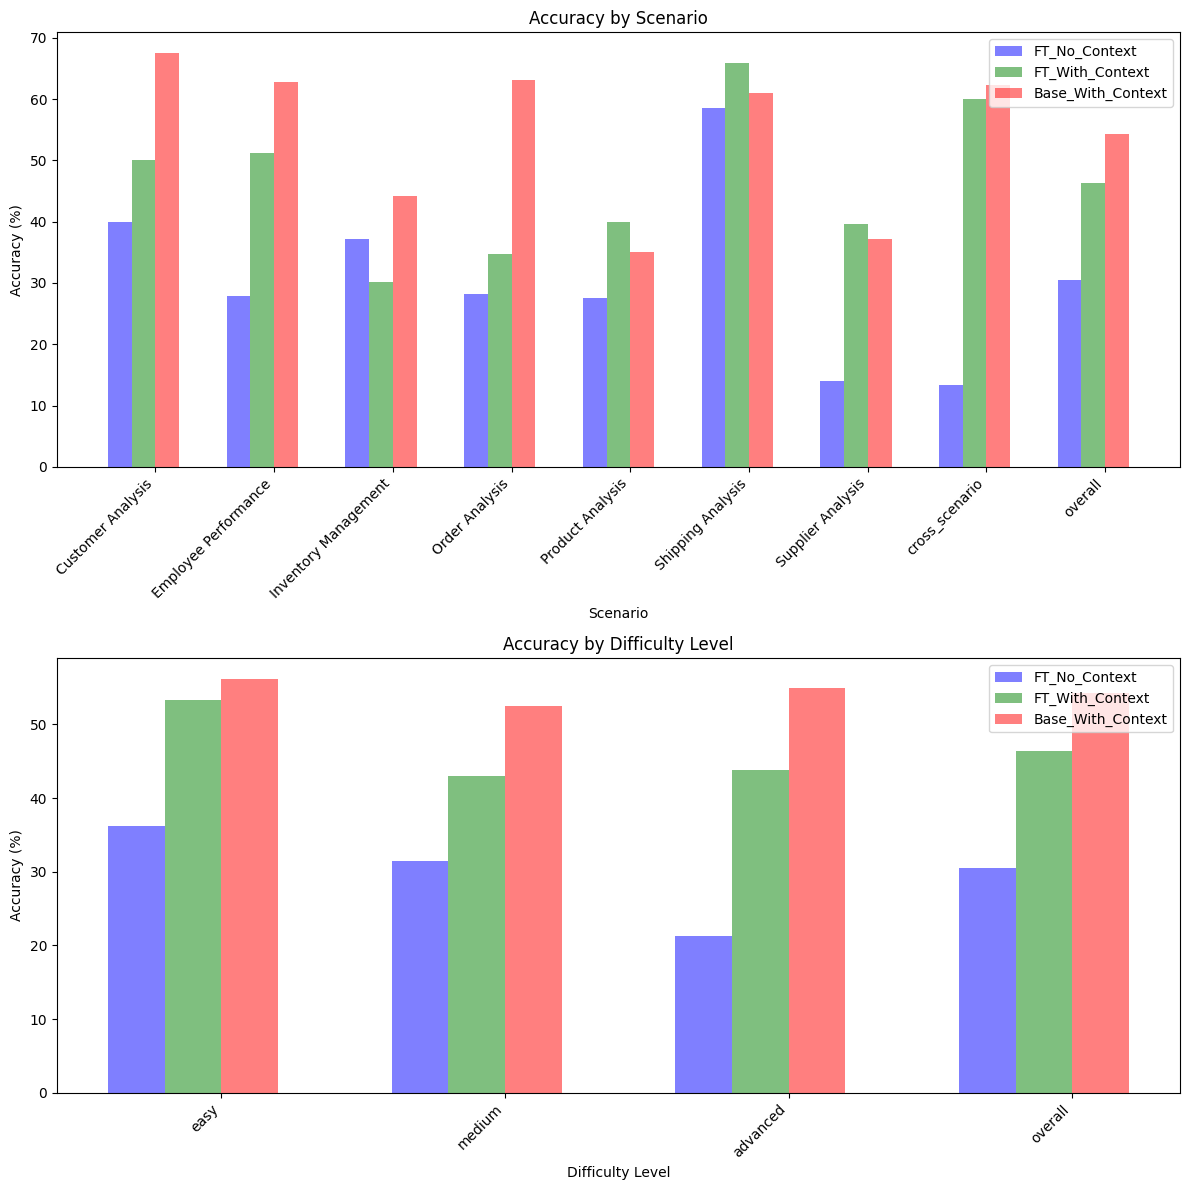

In [7]:
import os  
import json  
import matplotlib.pyplot as plt  
from pathlib import Path  
from dotenv import load_dotenv  
from openai import AzureOpenAI  
from collections import defaultdict  
from concurrent.futures import ThreadPoolExecutor  

# Load environment variables  
env_path = Path('.') / 'secrets.env'  
load_dotenv(dotenv_path=env_path)  
  
openaikey = os.getenv("AZURE_OPENAI_API_KEY")  
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")  
openaikey_base = os.getenv("AZURE_OPENAI_API_KEY_BASE")  
openaiservice_base = os.getenv("AZURE_OPENAI_ENDPOINT_BASE")  
  
# Initialize OpenAI client  
client = AzureOpenAI(api_key=openaikey, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice)  
client_base = AzureOpenAI(api_key=openaikey_base, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice_base)  
  
# Load the test dataset  
with open("../data/test_data_v3.json", "r") as file:  
    test_data = json.load(file)  
# Load the schema information  
with open("../data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
schema = json.dumps(ontology, indent=4)  
  
# Function to generate SQL queries using the first OpenAI model without context  
def generate_sql_query_no_context(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT2"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": "You are querying the MDDX database, what is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the first OpenAI model with context  
def generate_sql_query_with_context(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT2"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database, what is the SQL query for the following question? \n##Use the following schema information\n: {schema}"},  
            {"role": "user", "content": question},  
        ],  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the base OpenAI model with context  
def generate_sql_query_base_model_with_context(question):  
    response = client_base.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_BASE_DEPLOYMENT"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database. Use the following schema: {schema}. What is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
  
# Function to evaluate SQL queries using the second OpenAI model  
def evaluate_sql_query(question, generated_query, ground_truth_query):  
    user_message = f"""  
    You are a SQL expert. Given the following user question, generated SQL query, and the ground truth SQL query, evaluate whether the generated SQL query would give the same result as the ground truth query. The generated query does not have to be identical to the ground truth query.  
    ## Generated SQL Query  
    {generated_query}  
    ## Ground Truth SQL Query  
    {ground_truth_query}  
    Output format: Provide a single word answer as 'yes' or 'no'.  
    Your output:  
    """  
      
    def get_response():  
        response = client.chat.completions.create(  
            model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  # engine = "deployment_name".  
            messages=[  
                {"role": "system", "content": "You are a SQL expert"},  
                {"role": "user", "content": user_message},  
            ],  
            timeout=90,  
        )  
        return response.choices[0].message.content.strip().lower()  
      
    with ThreadPoolExecutor(max_workers=3) as executor:  
        votes = list(executor.map(lambda _: get_response(), range(5)))  
      
    # Take the majority vote  
    return 'yes' if votes.count('yes') > votes.count('no') else 'no'  
  
# Initialize dictionaries to store evaluation results  
results_by_setup = {  
    "FT_No_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "FT_With_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "Base_With_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
}  
  
# Generate SQL queries and evaluate them  
for item in test_data:  
    scenario = item["scenario"]  
    difficulty = item["difficulty"]  
    question = item["input"]  
    ground_truth_query = item["output"]  
  
    # Merge "hard" with "advanced"  
    if difficulty == "hard":  
        difficulty = "advanced"  
  
    # Generate SQL query using the first model without context  
    generated_query_no_context = generate_sql_query_no_context(question)  
  
    # Generate SQL query using the first model with context  
    generated_query_with_context_ft = generate_sql_query_with_context(question)  
  
    # Generate SQL query using the base model with context  
    generated_query_with_context_base = generate_sql_query_base_model_with_context(question)  
  
    # Evaluate the generated queries using the second model  
    evaluation_result_no_context = evaluate_sql_query(question, generated_query_no_context, ground_truth_query)  
    evaluation_result_with_context_ft = evaluate_sql_query(question, generated_query_with_context_ft, ground_truth_query)  
    evaluation_result_with_context_base = evaluate_sql_query(question, generated_query_with_context_base, ground_truth_query)  
  
    # Update results for no context  
    results_by_setup["FT_No_Context"][scenario]["total"] += 1  
    results_by_setup["FT_No_Context"][difficulty]["total"] += 1  
    if evaluation_result_no_context == 'yes':  
        results_by_setup["FT_No_Context"][scenario]["correct"] += 1  
        results_by_setup["FT_No_Context"][difficulty]["correct"] += 1  
  
    # Update results for context with fine-tuned model  
    results_by_setup["FT_With_Context"][scenario]["total"] += 1  
    results_by_setup["FT_With_Context"][difficulty]["total"] += 1  
    if evaluation_result_with_context_ft == 'yes':  
        results_by_setup["FT_With_Context"][scenario]["correct"] += 1  
        results_by_setup["FT_With_Context"][difficulty]["correct"] += 1  
  
    # Update results for context with base model  
    results_by_setup["Base_With_Context"][scenario]["total"] += 1  
    results_by_setup["Base_With_Context"][difficulty]["total"] += 1  
    if evaluation_result_with_context_base == 'yes':  
        results_by_setup["Base_With_Context"][scenario]["correct"] += 1  
        results_by_setup["Base_With_Context"][difficulty]["correct"] += 1  
  
# Calculate and print accuracy by scenario for each setup  
print("\nAccuracy by Scenario:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for scenario, counts in setup_results.items():  
        if scenario in ["easy", "medium", "advanced"]:  
            continue  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Scenario: {scenario}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Calculate and print accuracy by difficulty for each setup  
print("\nAccuracy by Difficulty Level:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for difficulty in ["easy", "medium", "advanced"]:  
        counts = setup_results[difficulty]  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Difficulty: {difficulty}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Visualize accuracy by scenario for each setup  
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))  
  
# Prepare data for plotting  
scenario_names = sorted(set(s for s in results_by_setup["FT_No_Context"] if s not in ["easy", "medium", "advanced"]))  
difficulty_levels = ["easy", "medium", "advanced"]  
all_scenarios = scenario_names + ["overall"]  
all_difficulties = difficulty_levels + ["overall"]  
  
# Calculate overall accuracies  
for setup_name, setup_results in results_by_setup.items():  
    overall_correct = sum(setup_results[s]["correct"] for s in scenario_names)  
    overall_total = sum(setup_results[s]["total"] for s in scenario_names)  
    setup_results["overall_scenario"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
    overall_correct = sum(setup_results[d]["correct"] for d in difficulty_levels)  
    overall_total = sum(setup_results[d]["total"] for d in difficulty_levels)  
    setup_results["overall_difficulty"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
  
# Plot accuracy by scenario  
width = 0.2  
x_scenario = range(len(all_scenarios))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green', 'red'])):  
    scenario_accuracies = [(results_by_setup[setup_name][s]["correct"] / results_by_setup[setup_name][s]["total"]) * 100 if results_by_setup[setup_name][s]["total"] > 0 else 0 for s in scenario_names] + [  
        (results_by_setup[setup_name]["overall_scenario"]["correct"] / results_by_setup[setup_name]["overall_scenario"]["total"]) * 100 if results_by_setup[setup_name]["overall_scenario"]["total"] > 0 else 0]  
    axes[0].bar([p + idx * width for p in x_scenario], scenario_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[0].set_title('Accuracy by Scenario')  
axes[0].set_xlabel('Scenario')  
axes[0].set_ylabel('Accuracy (%)')  
axes[0].set_xticks([p + 1.5 * width for p in x_scenario])  
axes[0].set_xticklabels(all_scenarios, rotation=45, ha='right')  
axes[0].legend()  
  
# Plot accuracy by difficulty  
x_difficulty = range(len(all_difficulties))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green', 'red'])):  
    difficulty_accuracies = [(results_by_setup[setup_name][d]["correct"] / results_by_setup[setup_name][d]["total"]) * 100 if results_by_setup[setup_name][d]["total"] > 0 else 0 for d in difficulty_levels] + [  
        (results_by_setup[setup_name]["overall_difficulty"]["correct"] / results_by_setup[setup_name]["overall_difficulty"]["total"]) * 100 if results_by_setup[setup_name]["overall_difficulty"]["total"] > 0 else 0]  
    axes[1].bar([p + idx * width for p in x_difficulty], difficulty_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[1].set_title('Accuracy by Difficulty Level')  
axes[1].set_xlabel('Difficulty Level')  
axes[1].set_ylabel('Accuracy (%)')  
axes[1].set_xticks([p + 1.5 * width for p in x_difficulty])  
axes[1].set_xticklabels(all_difficulties, rotation=45, ha='right')  
axes[1].legend()  
  
plt.tight_layout()  
plt.show()  

V3 checkpoint 2


Accuracy by Scenario:

Accuracy for FT_No_Context:
  Scenario: Supplier Analysis, Accuracy: 68.42%
  Scenario: cross_scenario, Accuracy: 25.00%
  Scenario: Customer Analysis, Accuracy: 72.97%
  Scenario: Inventory Management, Accuracy: 64.10%
  Scenario: Employee Performance, Accuracy: 56.41%
  Scenario: Order Analysis, Accuracy: 82.05%
  Scenario: Product Analysis, Accuracy: 62.16%
  Scenario: Shipping Analysis, Accuracy: 73.68%
  Overall Accuracy: 65.51%

Accuracy for FT_With_Context:
  Scenario: Supplier Analysis, Accuracy: 60.53%
  Scenario: cross_scenario, Accuracy: 45.00%
  Scenario: Customer Analysis, Accuracy: 70.27%
  Scenario: Inventory Management, Accuracy: 66.67%
  Scenario: Employee Performance, Accuracy: 69.23%
  Scenario: Order Analysis, Accuracy: 79.49%
  Scenario: Product Analysis, Accuracy: 59.46%
  Scenario: Shipping Analysis, Accuracy: 81.58%
  Overall Accuracy: 67.94%

Accuracy for Base_With_Context:
  Scenario: Supplier Analysis, Accuracy: 76.32%
  Scenario: cros

Text(0, 0.5, 'Accuracy (%)')

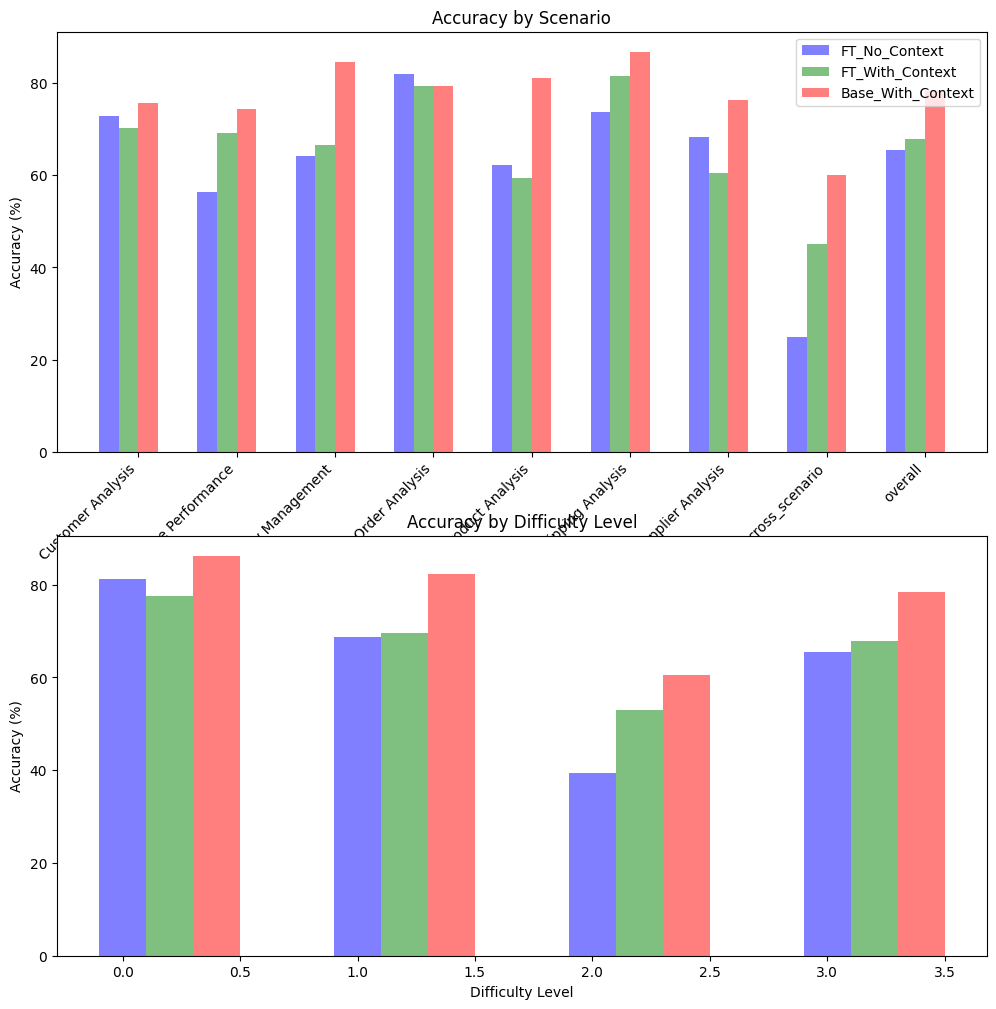

In [4]:
import os  
import json  
import matplotlib.pyplot as plt  
from pathlib import Path  
from dotenv import load_dotenv  
from openai import AzureOpenAI  
from collections import defaultdict  
from concurrent.futures import ThreadPoolExecutor  

# Load environment variables  
env_path = Path('.') / 'secrets.env'  
load_dotenv(dotenv_path=env_path)  
  
openaikey = os.getenv("AZURE_OPENAI_API_KEY")  
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")  
openaikey_base = os.getenv("AZURE_OPENAI_API_KEY_BASE")  
openaiservice_base = os.getenv("AZURE_OPENAI_ENDPOINT_BASE")  
  
# Initialize OpenAI client  
client = AzureOpenAI(api_key=openaikey, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice)  
client_base = AzureOpenAI(api_key=openaikey_base, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice_base)  
  
# Load the test dataset  
with open("../data/test_data_v2.json", "r") as file:  
    test_data = json.load(file)  
# Load the schema information  
with open("../data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
schema = json.dumps(ontology, indent=4)  
  
# Function to generate SQL queries using the first OpenAI model without context  
def generate_sql_query_no_context(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT2"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": "You are querying the MDDX database, what is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the first OpenAI model with context  
def generate_sql_query_with_context(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT2"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database. Use the following schema information\n: {schema}. \nWhat is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the base OpenAI model with context  
def generate_sql_query_base_model_with_context(question):  
    response = client_base.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_BASE_DEPLOYMENT"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database. Use the following schema: {schema}. What is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
  
# Function to evaluate SQL queries using the second OpenAI model  
def evaluate_sql_query(question, generated_query, ground_truth_query):  
    user_message = f"""  
    You are a SQL expert. Given the following user question, generated SQL query, and the ground truth SQL query, evaluate whether the generated SQL query would correctly answer the user's question. The generated query does not have to be identical to the ground truth query.  
    ## User Question  
    {question}  
    ## Generated SQL Query  
    {generated_query}  
    ## Ground Truth SQL Query  
    {ground_truth_query}  
    Output format: Provide a single word answer as 'yes' or 'no'.  
    Your output:  
    """  
      
    def get_response():  
        response = client.chat.completions.create(  
            model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  # engine = "deployment_name".  
            messages=[  
                {"role": "system", "content": "You are a SQL expert"},  
                {"role": "user", "content": user_message},  
            ],  
            timeout=90,  
        )  
        return response.choices[0].message.content.strip().lower()  
      
    with ThreadPoolExecutor(max_workers=3) as executor:  
        votes = list(executor.map(lambda _: get_response(), range(5)))  
      
    # Take the majority vote  
    return 'yes' if votes.count('yes') > votes.count('no') else 'no'  
  
# Initialize dictionaries to store evaluation results  
results_by_setup = {  
    "FT_No_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "FT_With_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "Base_With_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
}  
  
# Generate SQL queries and evaluate them  
for item in test_data:  
    scenario = item["scenario"]  
    difficulty = item["difficulty"]  
    question = item["input"]  
    ground_truth_query = item["output"]  
  
    # Merge "hard" with "advanced"  
    if difficulty == "hard":  
        difficulty = "advanced"  
  
    # Generate SQL query using the first model without context  
    generated_query_no_context = generate_sql_query_no_context(question)  
  
    # Generate SQL query using the first model with context  
    generated_query_with_context_ft = generate_sql_query_with_context(question)  
  
    # Generate SQL query using the base model with context  
    generated_query_with_context_base = generate_sql_query_base_model_with_context(question)  
  
    # Evaluate the generated queries using the second model  
    evaluation_result_no_context = evaluate_sql_query(question, generated_query_no_context, ground_truth_query)  
    evaluation_result_with_context_ft = evaluate_sql_query(question, generated_query_with_context_ft, ground_truth_query)  
    evaluation_result_with_context_base = evaluate_sql_query(question, generated_query_with_context_base, ground_truth_query)  
  
    # Update results for no context  
    results_by_setup["FT_No_Context"][scenario]["total"] += 1  
    results_by_setup["FT_No_Context"][difficulty]["total"] += 1  
    if evaluation_result_no_context == 'yes':  
        results_by_setup["FT_No_Context"][scenario]["correct"] += 1  
        results_by_setup["FT_No_Context"][difficulty]["correct"] += 1  
  
    # Update results for context with fine-tuned model  
    results_by_setup["FT_With_Context"][scenario]["total"] += 1  
    results_by_setup["FT_With_Context"][difficulty]["total"] += 1  
    if evaluation_result_with_context_ft == 'yes':  
        results_by_setup["FT_With_Context"][scenario]["correct"] += 1  
        results_by_setup["FT_With_Context"][difficulty]["correct"] += 1  
  
    # Update results for context with base model  
    results_by_setup["Base_With_Context"][scenario]["total"] += 1  
    results_by_setup["Base_With_Context"][difficulty]["total"] += 1  
    if evaluation_result_with_context_base == 'yes':  
        results_by_setup["Base_With_Context"][scenario]["correct"] += 1  
        results_by_setup["Base_With_Context"][difficulty]["correct"] += 1  
  
# Calculate and print accuracy by scenario for each setup  
print("\nAccuracy by Scenario:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for scenario, counts in setup_results.items():  
        if scenario in ["easy", "medium", "advanced"]:  
            continue  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Scenario: {scenario}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Calculate and print accuracy by difficulty for each setup  
print("\nAccuracy by Difficulty Level:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for difficulty in ["easy", "medium", "advanced"]:  
        counts = setup_results[difficulty]  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Difficulty: {difficulty}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Visualize accuracy by scenario for each setup  
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))  
  
# Prepare data for plotting  
scenario_names = sorted(set(s for s in results_by_setup["FT_No_Context"] if s not in ["easy", "medium", "advanced"]))  
difficulty_levels = ["easy", "medium", "advanced"]  
all_scenarios = scenario_names + ["overall"]  
all_difficulties = difficulty_levels + ["overall"]  
  
# Calculate overall accuracies  
for setup_name, setup_results in results_by_setup.items():  
    overall_correct = sum(setup_results[s]["correct"] for s in scenario_names)  
    overall_total = sum(setup_results[s]["total"] for s in scenario_names)  
    setup_results["overall_scenario"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
    overall_correct = sum(setup_results[d]["correct"] for d in difficulty_levels)  
    overall_total = sum(setup_results[d]["total"] for d in difficulty_levels)  
    setup_results["overall_difficulty"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
  
# Plot accuracy by scenario  
width = 0.2  
x_scenario = range(len(all_scenarios))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green', 'red'])):  
    scenario_accuracies = [(results_by_setup[setup_name][s]["correct"] / results_by_setup[setup_name][s]["total"]) * 100 if results_by_setup[setup_name][s]["total"] > 0 else 0 for s in scenario_names] + [  
        (results_by_setup[setup_name]["overall_scenario"]["correct"] / results_by_setup[setup_name]["overall_scenario"]["total"]) * 100 if results_by_setup[setup_name]["overall_scenario"]["total"] > 0 else 0]  
    axes[0].bar([p + idx * width for p in x_scenario], scenario_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[0].set_title('Accuracy by Scenario')  
axes[0].set_xlabel('Scenario')  
axes[0].set_ylabel('Accuracy (%)')  
axes[0].set_xticks([p + 1.5 * width for p in x_scenario])  
axes[0].set_xticklabels(all_scenarios, rotation=45, ha='right')  
axes[0].legend()  
  
# Plot accuracy by difficulty  
x_difficulty = range(len(all_difficulties))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green', 'red'])):  
    difficulty_accuracies = [(results_by_setup[setup_name][d]["correct"] / results_by_setup[setup_name][d]["total"]) * 100 if results_by_setup[setup_name][d]["total"] > 0 else 0 for d in difficulty_levels] + [  
        (results_by_setup[setup_name]["overall_difficulty"]["correct"] / results_by_setup[setup_name]["overall_difficulty"]["total"]) * 100 if results_by_setup[setup_name]["overall_difficulty"]["total"] > 0 else 0]  
    axes[1].bar([p + idx * width for p in x_difficulty], difficulty_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[1].set_title('Accuracy by Difficulty Level')  
axes[1].set_xlabel('Difficulty Level')  
axes[1].set_ylabel('Accuracy (%)')  

### Context data version


Accuracy by Scenario:

Accuracy for FT_With_Context:
  Scenario: Order Analysis, Accuracy: 71.74%
  Scenario: Product Analysis, Accuracy: 60.00%
  Scenario: Inventory Management, Accuracy: 60.47%
  Scenario: cross_scenario, Accuracy: 66.67%
  Scenario: Employee Performance, Accuracy: 79.07%
  Scenario: Shipping Analysis, Accuracy: 82.93%
  Scenario: Supplier Analysis, Accuracy: 69.77%
  Scenario: Customer Analysis, Accuracy: 77.50%
  Overall Accuracy: 70.97%

Accuracy for Base_With_Context:
  Scenario: Order Analysis, Accuracy: 71.74%
  Scenario: Product Analysis, Accuracy: 62.50%
  Scenario: Inventory Management, Accuracy: 69.77%
  Scenario: cross_scenario, Accuracy: 57.78%
  Scenario: Employee Performance, Accuracy: 79.07%
  Scenario: Shipping Analysis, Accuracy: 78.05%
  Scenario: Supplier Analysis, Accuracy: 72.09%
  Scenario: Customer Analysis, Accuracy: 72.50%
  Overall Accuracy: 70.38%

Accuracy by Difficulty Level:

Accuracy for FT_With_Context:
  Difficulty: easy, Accuracy: 7

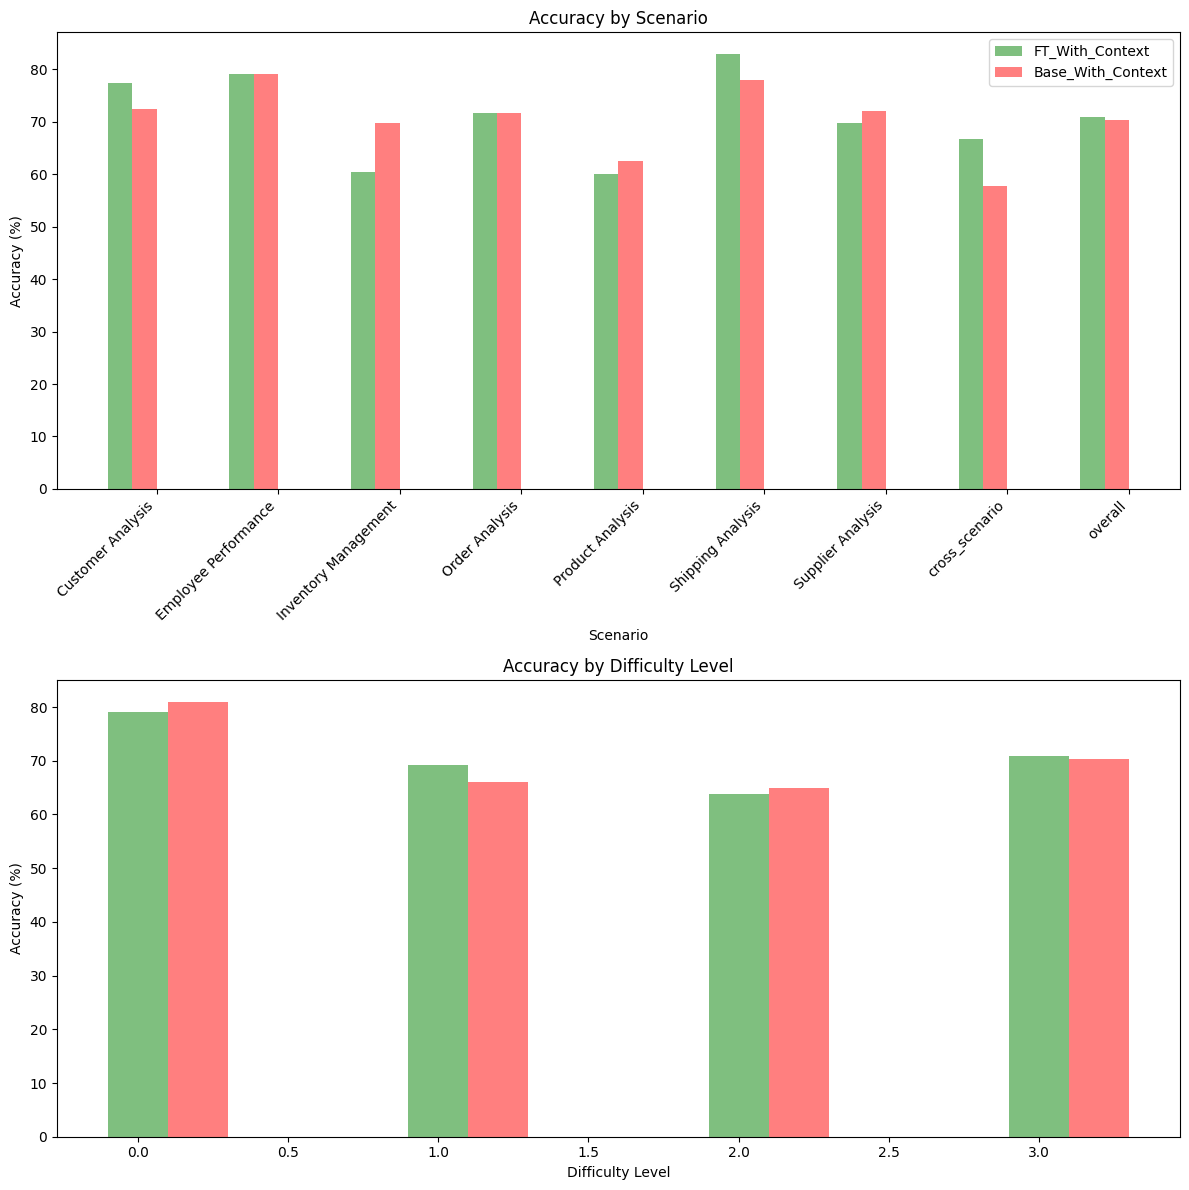

In [14]:
import os  
import json  
import matplotlib.pyplot as plt  
from pathlib import Path  
from dotenv import load_dotenv  
from openai import AzureOpenAI  
from collections import defaultdict  
from concurrent.futures import ThreadPoolExecutor  
import csv  
from tenacity import retry, wait_random_exponential, stop_after_attempt, stop_after_delay  

# Load environment variables  
env_path = Path('.') / 'secrets.env'  
load_dotenv(dotenv_path=env_path)  
  
openaikey = os.getenv("AZURE_OPENAI_API_KEY")  
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")  
openaikey_base = os.getenv("AZURE_OPENAI_API_KEY_BASE")  
openaiservice_base = os.getenv("AZURE_OPENAI_ENDPOINT_BASE")  
  
# Initialize OpenAI client  
client = AzureOpenAI(api_key=openaikey, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice)  
client_base = AzureOpenAI(api_key=openaikey_base, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice_base)  
  
# Load the test dataset  
with open("../data/test_data_v3.json", "r") as file:  
    test_data = json.load(file)  
  
# Load the schema information  
with open("../data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
schema = json.dumps(ontology, indent=4)  
  
split_scenarios = {}  
for scenario in ontology["business_scenarios"]:  
    scenario_name = scenario["scenario"]  
    split_scenarios[scenario_name] = {  
        "date_format": ontology["date_format"],  
        "scenario": scenario,  
        "tables": {},  
        "metrics": []  
    }  
    for mapping in ontology["scenario_metric_mapping"]:  
        if mapping["scenario"] == scenario_name:  
            for metric_name in mapping["metrics"]:  
                for metric in ontology["business_metrics"]:  
                    if metric["name"] == metric_name:  
                        split_scenarios[scenario_name]["metrics"].append(metric)  
                        for table in metric["tables"]:  
                            if table not in split_scenarios[scenario_name]["tables"]:  
                                split_scenarios[scenario_name]["tables"][table] = ontology["tables"][table]  
  
split_scenarios["cross_scenario"] = json.dumps(ontology, indent=4)  
  
# Function to generate SQL queries using the first OpenAI model with context  
def generate_sql_query_with_ft(question, schema):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT2"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database. What is the SQL query for the following question?"},  
            {"role": "user", "content": f"## Database Schema and Business Metrics Definitions\n{schema}\n\n## Question: " + question},  
        ],  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the base OpenAI model with context  
def generate_sql_query_base_model_with_context(question):  
    response = client_base.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_BASE_DEPLOYMENT"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database. Use the following schema: {schema}. What is the SQL query for the following question? Only respond with a SQL query, do not add any explanation"},  
            {"role": "user", "content": question},  
        ],  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to evaluate SQL queries using the second OpenAI model  
@retry(wait=wait_random_exponential(multiplier=1, max=60), stop=(stop_after_attempt(10) | stop_after_delay(300)))  
def evaluate_sql_query(question, generated_query, ground_truth_query):  
    user_message = f"""  
    You are a SQL expert. Given the following user question, generated SQL query, and the ground truth SQL query, evaluate whether the generated SQL query would answer the question correctly. The generated query does not have to be identical to the ground truth query but the schema has to be correct. Column labels of result sets can be different as long as they answer the question.  
    ## User Question  
    {question}  
    ## Generated SQL Query  
    {generated_query}  
    ## Ground Truth SQL Query  
    {ground_truth_query}  
    Output format: Provide a single word answer as 'yes' or 'no'. Also, provide a brief explanation in JSON format as {{"result": "yes/no", "explanation": "explanation"}}.  
    Your output:  
    """  
  
    def get_response():  
        response = client.chat.completions.create(  
            model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  # engine = "deployment_name".  
            messages=[  
                {"role": "system", "content": "You are a SQL expert"},  
                {"role": "user", "content": user_message},  
            ],  
            response_format={"type": "json_object"},  
        )  
        response_message = json.loads(response.choices[0].message.content)  
        return response_message  
  
    with ThreadPoolExecutor(max_workers=3) as executor:  
        responses = list(executor.map(lambda _: get_response(), range(5)))  
  
    # Take the majority vote for 'yes' or 'no'  
    votes = [response["result"].lower() for response in responses]  
    explanations = [response["explanation"] for response in responses]  
  
    majority_vote = 'yes' if votes.count('yes') > votes.count('no') else 'no'  
    # Find the first explanation that matches the majority vote  
    explanation = next((explanations[i] for i in range(len(votes)) if votes[i] == majority_vote), "")  
    return majority_vote, explanation  
  
# Initialize dictionaries to store evaluation results  
results_by_setup = {  
    "FT_With_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "Base_With_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
}  
  
# List to store CSV rows  
csv_rows = []  
  
# Generate SQL queries and evaluate them  
for item in test_data:  
    scenario = item["scenario"]  
    difficulty = item["difficulty"]  
    question = item["input"]  
    ground_truth_query = item["output"]  
  
    # Merge "hard" with "advanced"  
    if difficulty == "hard":  
        difficulty = "advanced"  
    schema = json.dumps(split_scenarios[item["scenario"]], indent=4) if item["scenario"] != "cross_scenario" else split_scenarios["cross_scenario"]  
  
    # Generate SQL query using the first model with context  
    generated_query_with_context_ft = generate_sql_query_with_ft(question, schema)  
  
    # Generate SQL query using the base model with context  
    generated_query_with_context_base = generate_sql_query_base_model_with_context(question)  
  
    # Evaluate the generated queries using the second model  
    evaluation_result_with_context_ft, explanation_ft = evaluate_sql_query(question, generated_query_with_context_ft, ground_truth_query)  
    evaluation_result_with_context_base, explanation_base = evaluate_sql_query(question, generated_query_with_context_base, ground_truth_query)  
  
    # Update results for context with fine-tuned model  
    results_by_setup["FT_With_Context"][scenario]["total"] += 1  
    results_by_setup["FT_With_Context"][difficulty]["total"] += 1  
    if evaluation_result_with_context_ft == 'yes':  
        results_by_setup["FT_With_Context"][scenario]["correct"] += 1  
        results_by_setup["FT_With_Context"][difficulty]["correct"] += 1  
  
    # Update results for context with base model  
    results_by_setup["Base_With_Context"][scenario]["total"] += 1  
    results_by_setup["Base_With_Context"][difficulty]["total"] += 1  
    if evaluation_result_with_context_base == 'yes':  
        results_by_setup["Base_With_Context"][scenario]["correct"] += 1  
        results_by_setup["Base_With_Context"][difficulty]["correct"] += 1  
  
    # Collect data for CSV  
    ft_correct = evaluation_result_with_context_ft == 'yes'  
    base_correct = evaluation_result_with_context_base == 'yes'  
    if ft_correct and not base_correct:  
        csv_rows.append([question, ground_truth_query, generated_query_with_context_ft, explanation_ft, generated_query_with_context_base, explanation_base, "FT", "Base"])  
    elif not ft_correct and base_correct:  
        csv_rows.append([question, ground_truth_query, generated_query_with_context_ft, explanation_ft, generated_query_with_context_base, explanation_base, "Base", "FT"])  
    elif not ft_correct and not base_correct:  
        csv_rows.append([question, ground_truth_query, generated_query_with_context_ft, explanation_ft, generated_query_with_context_base, explanation_base, "Both", "None"])  
  
# Write CSV  
with open("evaluation_results.csv", "w", newline="") as csvfile:  
    csvwriter = csv.writer(csvfile)  
    csvwriter.writerow(["Question","Ground Truth Query", "Generated Query by FT", "Explanation by FT", "Generated Query by Base Model", "Explanation by Base Model", "Model that got it right", "Model that got it wrong"])  
    csvwriter.writerows(csv_rows)  
  
# Calculate and print accuracy by scenario for each setup  
print("\nAccuracy by Scenario:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for scenario, counts in setup_results.items():  
        if scenario in ["easy", "medium", "advanced"]:  
            continue  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Scenario: {scenario}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Calculate and print accuracy by difficulty for each setup  
print("\nAccuracy by Difficulty Level:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for difficulty in ["easy", "medium", "advanced"]:  
        counts = setup_results[difficulty]  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Difficulty: {difficulty}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Visualize accuracy by scenario for each setup  
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))  
  
# Prepare data for plotting  
scenario_names = sorted(set(s for s in results_by_setup["FT_With_Context"] if s not in ["easy", "medium", "advanced"]))  
difficulty_levels = ["easy", "medium", "advanced"]  
all_scenarios = scenario_names + ["overall"]  
all_difficulties = difficulty_levels + ["overall"]  
  
# Calculate overall accuracies  
for setup_name, setup_results in results_by_setup.items():  
    overall_correct = sum(setup_results[s]["correct"] for s in scenario_names)  
    overall_total = sum(setup_results[s]["total"] for s in scenario_names)  
    setup_results["overall_scenario"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
    overall_correct = sum(setup_results[d]["correct"] for d in difficulty_levels)  
    overall_total = sum(setup_results[d]["total"] for d in difficulty_levels)  
    setup_results["overall_difficulty"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
  
# Plot accuracy by scenario  
width = 0.2  
x_scenario = range(len(all_scenarios))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['green', 'red'])):  
    scenario_accuracies = [(results_by_setup[setup_name][s]["correct"] / results_by_setup[setup_name][s]["total"]) * 100 if results_by_setup[setup_name][s]["total"] > 0 else 0 for s in scenario_names] + [  
        (results_by_setup[setup_name]["overall_scenario"]["correct"] / results_by_setup[setup_name]["overall_scenario"]["total"]) * 100 if results_by_setup[setup_name]["overall_scenario"]["total"] > 0 else 0]  
    axes[0].bar([p + idx * width for p in x_scenario], scenario_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[0].set_title('Accuracy by Scenario')  
axes[0].set_xlabel('Scenario')  
axes[0].set_ylabel('Accuracy (%)')  
axes[0].set_xticks([p + 1.5 * width for p in x_scenario])  
axes[0].set_xticklabels(all_scenarios, rotation=45, ha='right')  
axes[0].legend()  
  
# Plot accuracy by difficulty  
x_difficulty = range(len(all_difficulties))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['green', 'red'])):  
    difficulty_accuracies = [(results_by_setup[setup_name][d]["correct"] / results_by_setup[setup_name][d]["total"]) * 100 if results_by_setup[setup_name][d]["total"] > 0 else 0 for d in difficulty_levels] + [  
        (results_by_setup[setup_name]["overall_difficulty"]["correct"] / results_by_setup[setup_name]["overall_difficulty"]["total"]) * 100 if results_by_setup[setup_name]["overall_difficulty"]["total"] > 0 else 0]  
    axes[1].bar([p + idx * width for p in x_difficulty], difficulty_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[1].set_title('Accuracy by Difficulty Level')  
axes[1].set_xlabel('Difficulty Level')  
axes[1].set_ylabel('Accuracy (%)')  
  
plt.tight_layout()  
plt.show()  



Accuracy by Scenario:

Accuracy for FT_With_Context:
  Scenario: Supplier Analysis, Accuracy: 76.32%
  Scenario: cross_scenario, Accuracy: 45.00%
  Scenario: Customer Analysis, Accuracy: 75.68%
  Scenario: Inventory Management, Accuracy: 69.23%
  Scenario: Employee Performance, Accuracy: 69.23%
  Scenario: Order Analysis, Accuracy: 87.18%
  Scenario: Product Analysis, Accuracy: 54.05%
  Scenario: Shipping Analysis, Accuracy: 92.11%
  Overall Accuracy: 72.82%

Accuracy for Base_With_Context:
  Scenario: Supplier Analysis, Accuracy: 78.95%
  Scenario: cross_scenario, Accuracy: 65.00%
  Scenario: Customer Analysis, Accuracy: 83.78%
  Scenario: Inventory Management, Accuracy: 87.18%
  Scenario: Employee Performance, Accuracy: 74.36%
  Scenario: Order Analysis, Accuracy: 82.05%
  Scenario: Product Analysis, Accuracy: 70.27%
  Scenario: Shipping Analysis, Accuracy: 94.74%
  Overall Accuracy: 80.49%

Accuracy by Difficulty Level:

Accuracy for FT_With_Context:
  Difficulty: easy, Accuracy: 85.00%
  Difficulty: medium, Accuracy: 73.05%
  Difficulty: advanced, Accuracy: 57.58%
  Overall Accuracy: 72.82%

Accuracy for Base_With_Context:
  Difficulty: easy, Accuracy: 87.50%
  Difficulty: medium, Accuracy: 79.43%
  Difficulty: advanced, Accuracy: 74.24%
  Overall Accuracy: 80.49%


Accuracy by Scenario:

Accuracy for Base_Model:
  Scenario: Supplier Analysis, Accuracy: 68.42%
  Scenario: Order Analysis, Accuracy: 63.16%
  Scenario: Product Analysis, Accuracy: 36.84%
  Scenario: Employee Performance, Accuracy: 53.85%
  Scenario: Inventory Management, Accuracy: 47.37%
  Scenario: Shipping Analysis, Accuracy: 81.08%
  Scenario: Customer Analysis, Accuracy: 72.97%
  Scenario: cross_scenario, Accuracy: 35.00%
  Overall Accuracy: 58.60%

Accuracy for Finetuned_Model:
  Scenario: Supplier Analysis, Accuracy: 60.53%
  Scenario: Order Analysis, Accuracy: 57.89%
  Scenario: Product Analysis, Accuracy: 50.00%
  Scenario: Employee Performance, Accuracy: 69.23%
  Scenario: Inventory Management, Accuracy: 52.63%
  Scenario: Shipping Analysis, Accuracy: 64.86%
  Scenario: Customer Analysis, Accuracy: 75.68%
  Scenario: cross_scenario, Accuracy: 35.00%
  Overall Accuracy: 59.65%

Accuracy by Difficulty Level:

Accuracy for Base_Model:
  Difficulty: easy, Accuracy: 62.82%
  Diff

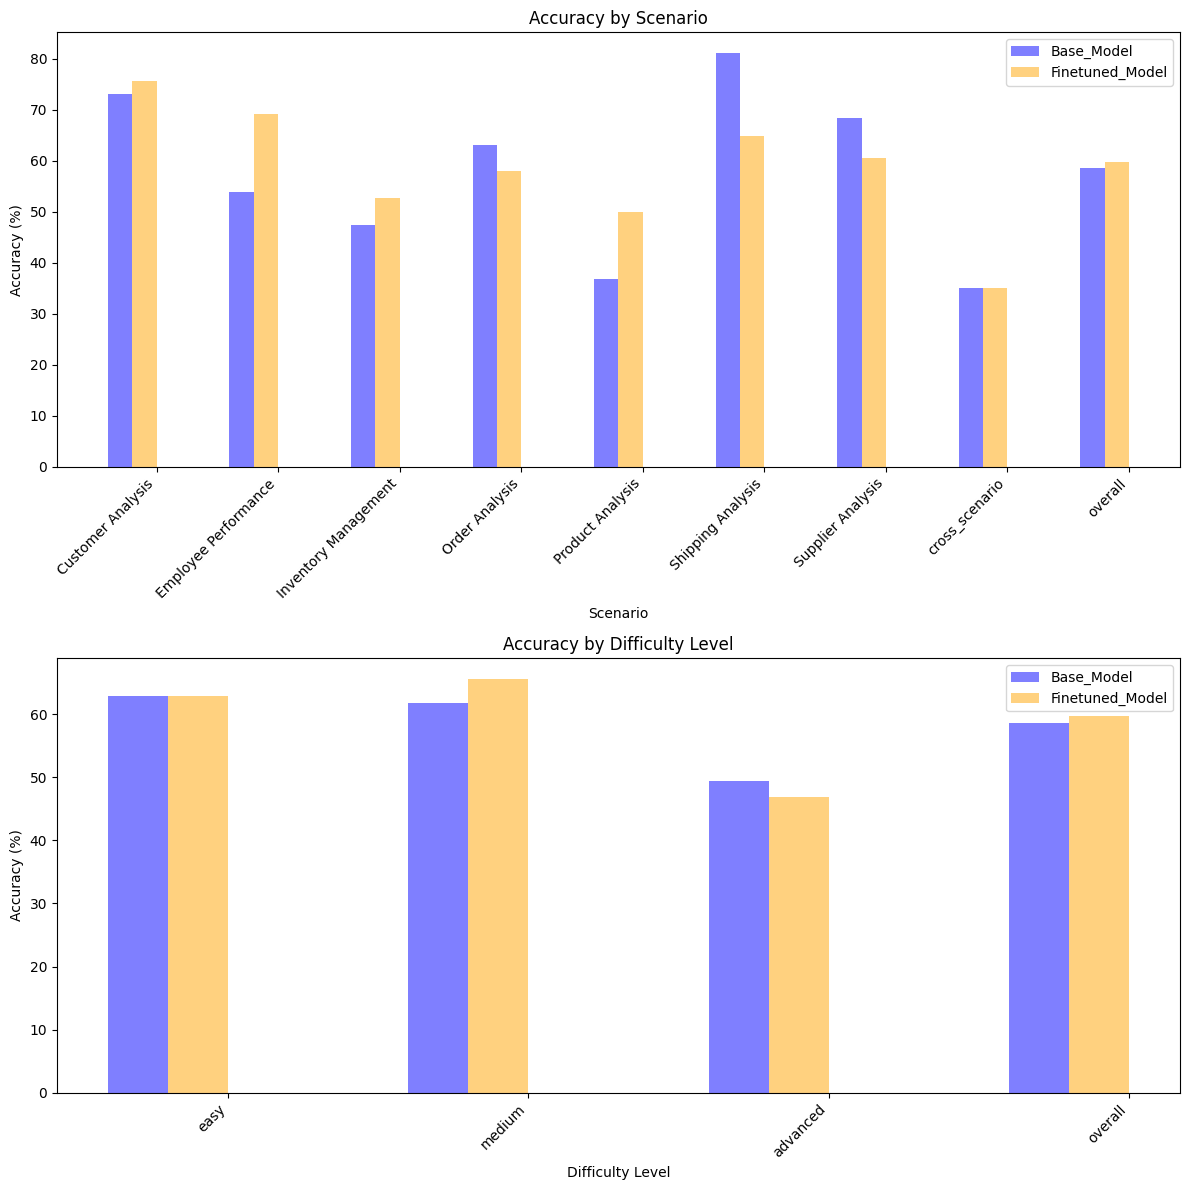

In [4]:
import os  
import json  
import matplotlib.pyplot as plt  
from pathlib import Path  
from dotenv import load_dotenv  
from openai import AzureOpenAI  
from collections import defaultdict  
from concurrent.futures import ThreadPoolExecutor  
  
# Load environment variables  
env_path = Path('.') / 'secrets.env'  
load_dotenv(dotenv_path=env_path)  
  
openaikey = os.getenv("AZURE_OPENAI_API_KEY")  
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")  
openaikey_base = os.getenv("AZURE_OPENAI_API_KEY_BASE")  
openaiservice_base = os.getenv("AZURE_OPENAI_ENDPOINT_BASE")  
  
# Initialize OpenAI client  
client = AzureOpenAI(api_key=openaikey, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice)  
client_base = AzureOpenAI(api_key=openaikey_base, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice_base)  
  
# Load the test dataset  
with open("../data/processed_test_data_v3.json", "r") as file:  
    test_data = json.load(file)  
  
# Load the schema information  
with open("../data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
  
split_scenarios = {}  
for scenario in ontology["business_scenarios"]:  
    scenario_name = scenario["scenario"]  
    split_scenarios[scenario_name] = {  
        "date_format": ontology["date_format"],  
        "scenario": scenario,  
        "tables": {},  
        "metrics": []  
    }  
    for mapping in ontology["scenario_metric_mapping"]:  
        if mapping["scenario"] == scenario_name:  
            for metric_name in mapping["metrics"]:  
                for metric in ontology["business_metrics"]:  
                    if metric["name"] == metric_name:  
                        split_scenarios[scenario_name]["metrics"].append(metric)  
                        for table in metric["tables"]:  
                            if table not in split_scenarios[scenario_name]["tables"]:  
                                split_scenarios[scenario_name]["tables"][table] = ontology["tables"][table]  
  
split_scenarios["cross_scenario"] = json.dumps(ontology, indent=4)  
  
# Function to generate Python code using the base OpenAI model with augmented prompt  
def generate_python_code_base_model(business_analytic_request, schema):  
    user_message = f"""  
    You are a great python developer. Given the following business analytic request, generate syntactically correct python code that works with the specification of the python environment and meets the requirements of the business request.  
    ## Business Analytic Request  
    {business_analytic_request}  
    ## Database Schema and Business Metrics Definitions  
    {schema}  
    ## Python environment constraint:  
    You are provided with following utility python functions to use INSIDE your code:  
    1. execute_sql_query(sql_query: str) - a function to execute SQL query against the SQL database to retrieve data you need. This function returns a pandas dataframe that you can use to perform any data analysis and visualization.  
    2. show_to_user(data) - a util function to display the data analysis and visualization result from this environment to user. This function can take a pandas dataframe or plotly figure as input. For example, to visualize a plotly figure, the code can be ```fig=px.line(some_df)\n show_to_user(fig)```. Only use plotly for graph visualization.  
    Output format: You write the generated python code into json format as {{"python_code": "executable python code for the request"}}.  
    Your output:  
    """  
    response = client_base.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_BASE_DEPLOYMENT"),  
        messages=[  
            {"role": "system", "content": "You are a great python developer"},  
            {"role": "user", "content": user_message},  
        ],  
        response_format={"type": "json_object"},  
    )  
    response_message = json.loads(response.choices[0].message.content)  
    return response_message["python_code"]  
  
# Function to generate Python code using the finetuned OpenAI model  
def generate_python_code_finetuned_model(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT_PYTHON"),  
        messages=[  
            {"role": "system", "content": "Write Python code that can provide answer for user request. You are working on MDDX database"},  
            {"role": "user", "content": question},  
        ],  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to evaluate Python code  
def evaluate_python_code(business_analytic_request, generated_python_code, ground_truth_code):  
    user_message = f"""  
    Your task is to evaluate the correctness of a given Python code based on a specified business analytic request and a reference implementation.

    ## Business Analytic Request  
    {business_analytic_request}  
    ## Reference Python Code Implementation 
    {ground_truth_code}  
    ## Input Python Code To Evaluate
    {generated_python_code}  
    ## Python environment constraint:  
    The Python code is supposed to run with following utility python functions:  
    1. execute_sql_query(sql_query: str) - a function to execute SQL query against the SQL database to retrieve data you need. This function returns a pandas dataframe that you can use to perform any data analysis and visualization.  
    2. show_to_user(data) - a util function to display the data analysis and visualization result from this environment to user. This function can take a pandas dataframe or plotly figure as input. For example, to visualize a plotly figure, the code can be ```fig=px.line(some_df)\n show_to_user(fig)```. Only use plotly for graph visualization.  
    Output format: Provide a single word answer as 'yes' or 'no'.  
    Provide a single-word answer: 'yes' or 'no'.
    'yes' if the input Python code produces the same result as the reference implementation and use the utility functions correctly, even if the code is not identical.
    'no' if otherwise.
    Your output:  
    """  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  
        messages=[  
            {"role": "system", "content": "You are a Python code reviewer"},  
            {"role": "user", "content": user_message},  
        ],  
    )  
    return response.choices[0].message.content.strip().lower()  
  
# Initialize dictionaries to store evaluation results  
results_by_setup = {  
    "Base_Model": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "Finetuned_Model": defaultdict(lambda: {"correct": 0, "total": 0}),  
}  
  
# Generate Python code and evaluate them  
for item in test_data:  
    scenario = item["scenario"]  
    difficulty = item["difficulty"]  
    business_analytic_request = item["input"]  
    ground_truth_code = item["output"]  # Assuming ground_truth_code is present in the test data  
  
    # Merge "hard" with "advanced"  
    if difficulty == "hard":  
        difficulty = "advanced"  
      
    schema = json.dumps(split_scenarios[item["scenario"]], indent=4) if item["scenario"] != "cross_scenario" else split_scenarios["cross_scenario"]  
      
    # Generate Python code using the base model with augmented prompt  
    generated_code_base_model = generate_python_code_base_model(business_analytic_request, schema)  
      
    # Generate Python code using the finetuned model with its training prompts  
    generated_code_finetuned_model = generate_python_code_finetuned_model(business_analytic_request)  
      
    # Evaluate the generated codes  
    evaluation_result_base_model = evaluate_python_code(business_analytic_request, generated_code_base_model, ground_truth_code)  
    evaluation_result_finetuned_model = evaluate_python_code(business_analytic_request, generated_code_finetuned_model, ground_truth_code)  
      
    # Update results for base model  
    results_by_setup["Base_Model"][scenario]["total"] += 1  
    results_by_setup["Base_Model"][difficulty]["total"] += 1  
    if evaluation_result_base_model == 'yes':  
        results_by_setup["Base_Model"][scenario]["correct"] += 1  
        results_by_setup["Base_Model"][difficulty]["correct"] += 1  
      
    # Update results for finetuned model  
    results_by_setup["Finetuned_Model"][scenario]["total"] += 1  
    results_by_setup["Finetuned_Model"][difficulty]["total"] += 1  
    if evaluation_result_finetuned_model == 'yes':  
        results_by_setup["Finetuned_Model"][scenario]["correct"] += 1  
        results_by_setup["Finetuned_Model"][difficulty]["correct"] += 1  
  
# Calculate and print accuracy by scenario for each setup  
print("\nAccuracy by Scenario:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for scenario, counts in setup_results.items():  
        if scenario in ["easy", "medium", "advanced"]:  
            continue  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Scenario: {scenario}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Calculate and print accuracy by difficulty for each setup  
print("\nAccuracy by Difficulty Level:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for difficulty in ["easy", "medium", "advanced"]:  
        counts = setup_results[difficulty]  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Difficulty: {difficulty}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Visualize accuracy by scenario for each setup  
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))  
  
# Prepare data for plotting  
scenario_names = sorted(set(s for s in results_by_setup["Base_Model"] if s not in ["easy", "medium", "advanced"]))  
difficulty_levels = ["easy", "medium", "advanced"]  
all_scenarios = scenario_names + ["overall"]  
all_difficulties = difficulty_levels + ["overall"]  
  
# Calculate overall accuracies  
for setup_name, setup_results in results_by_setup.items():  
    overall_correct = sum(setup_results[s]["correct"] for s in scenario_names)  
    overall_total = sum(setup_results[s]["total"] for s in scenario_names)  
    setup_results["overall_scenario"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
    overall_correct = sum(setup_results[d]["correct"] for d in difficulty_levels)  
    overall_total = sum(setup_results[d]["total"] for d in difficulty_levels)  
    setup_results["overall_difficulty"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
  
# Plot accuracy by scenario  
width = 0.2  
x_scenario = range(len(all_scenarios))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'orange'])):  
    scenario_accuracies = [(results_by_setup[setup_name][s]["correct"] / results_by_setup[setup_name][s]["total"]) * 100 if results_by_setup[setup_name][s]["total"] > 0 else 0 for s in scenario_names] + [  
        (results_by_setup[setup_name]["overall_scenario"]["correct"] / results_by_setup[setup_name]["overall_scenario"]["total"]) * 100 if results_by_setup[setup_name]["overall_scenario"]["total"] > 0 else 0]  
    axes[0].bar([p + idx * width for p in x_scenario], scenario_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[0].set_title('Accuracy by Scenario')  
axes[0].set_xlabel('Scenario')  
axes[0].set_ylabel('Accuracy (%)')  
axes[0].set_xticks([p + 1.5 * width for p in x_scenario])  
axes[0].set_xticklabels(all_scenarios, rotation=45, ha='right')  
axes[0].legend()  
  
# Plot accuracy by difficulty  
x_difficulty = range(len(all_difficulties))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'orange'])):  
    difficulty_accuracies = [(results_by_setup[setup_name][d]["correct"] / results_by_setup[setup_name][d]["total"]) * 100 if results_by_setup[setup_name][d]["total"] > 0 else 0 for d in difficulty_levels] + [  
        (results_by_setup[setup_name]["overall_difficulty"]["correct"] / results_by_setup[setup_name]["overall_difficulty"]["total"]) * 100 if results_by_setup[setup_name]["overall_difficulty"]["total"] > 0 else 0]  
    axes[1].bar([p + idx * width for p in x_difficulty], difficulty_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[1].set_title('Accuracy by Difficulty Level')  
axes[1].set_xlabel('Difficulty Level')  
axes[1].set_ylabel('Accuracy (%)')  
axes[1].set_xticks([p + 1.5 * width for p in x_difficulty])  
axes[1].set_xticklabels(all_difficulties, rotation=45, ha='right')  
axes[1].legend()  
  
# Show the plots  
plt.tight_layout()  
plt.show()  



Accuracy by Scenario:

Accuracy for Base_Model:
  Scenario: Order Analysis, Accuracy: 76.09%
  Scenario: Product Analysis, Accuracy: 67.50%
  Scenario: Inventory Management, Accuracy: 67.44%
  Scenario: cross_scenario, Accuracy: 62.22%
  Scenario: Employee Performance, Accuracy: 69.77%
  Scenario: Shipping Analysis, Accuracy: 78.05%
  Scenario: Supplier Analysis, Accuracy: 67.44%
  Scenario: Customer Analysis, Accuracy: 85.00%
  Overall Accuracy: 71.55%

Accuracy for Finetuned_Model:
  Scenario: Order Analysis, Accuracy: 78.26%
  Scenario: Product Analysis, Accuracy: 70.00%
  Scenario: Inventory Management, Accuracy: 55.81%
  Scenario: cross_scenario, Accuracy: 60.00%
  Scenario: Employee Performance, Accuracy: 69.77%
  Scenario: Shipping Analysis, Accuracy: 75.61%
  Scenario: Supplier Analysis, Accuracy: 46.51%
  Scenario: Customer Analysis, Accuracy: 60.00%
  Overall Accuracy: 64.52%

Accuracy by Difficulty Level:

Accuracy for Base_Model:
  Difficulty: easy, Accuracy: 71.43%
  Diff

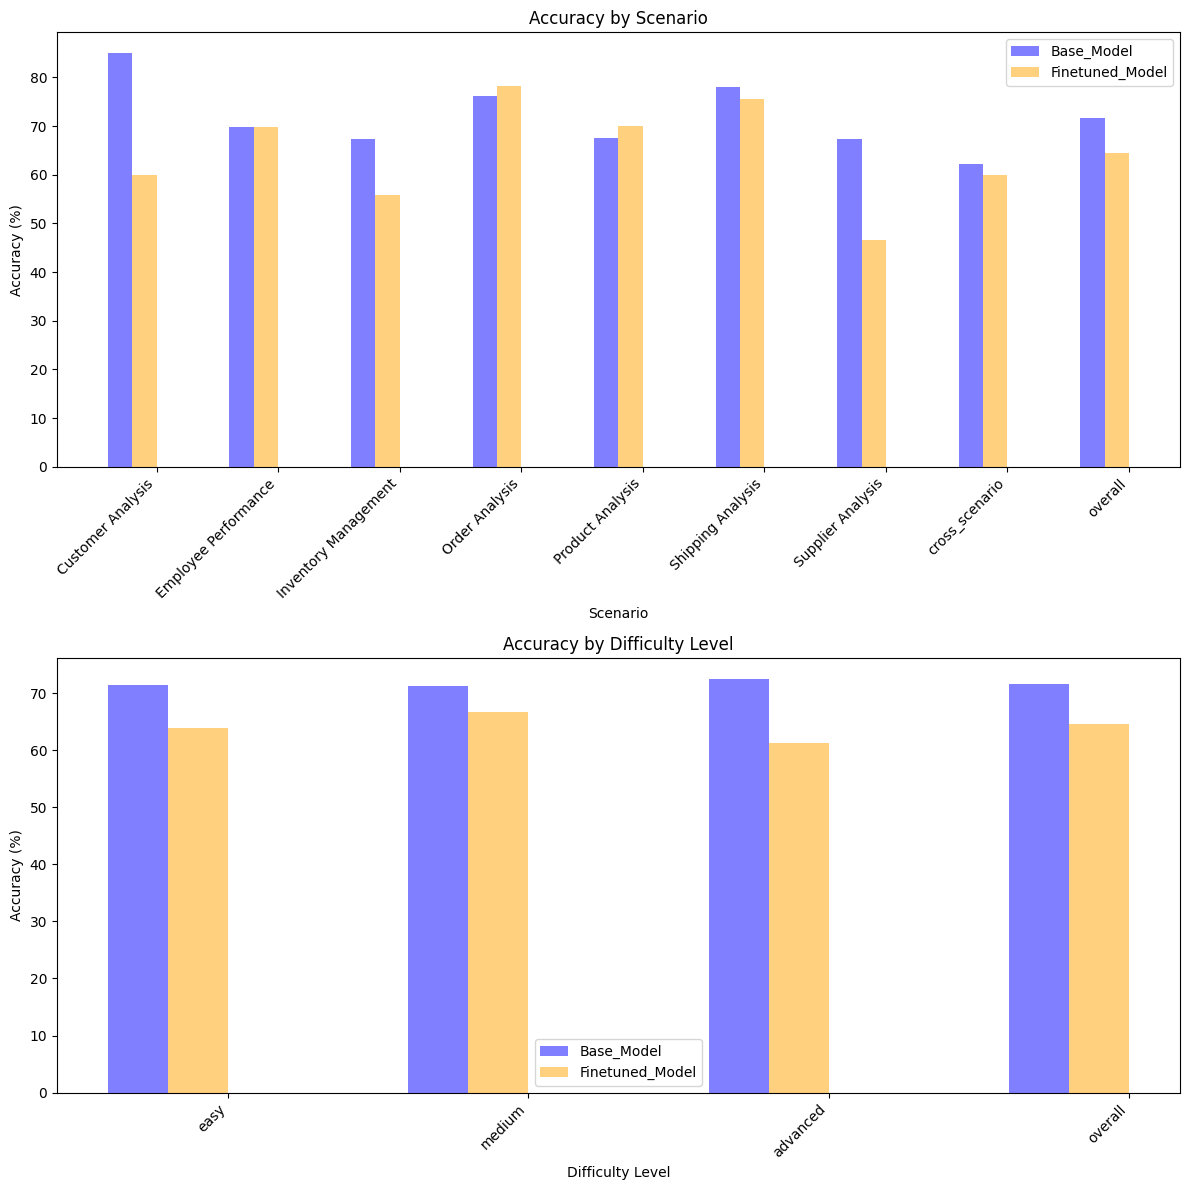

In [15]:
import os  
import json  
import matplotlib.pyplot as plt  
from pathlib import Path  
from dotenv import load_dotenv  
from openai import AzureOpenAI  
from collections import defaultdict  
import csv  
  
# Load environment variables  
env_path = Path('.') / 'secrets.env'  
load_dotenv(dotenv_path=env_path)  
  
openaikey = os.getenv("AZURE_OPENAI_API_KEY")  
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")  
openaikey_base = os.getenv("AZURE_OPENAI_API_KEY_BASE")  
openaiservice_base = os.getenv("AZURE_OPENAI_ENDPOINT_BASE")  
  
# Initialize OpenAI client  
client = AzureOpenAI(api_key=openaikey, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice)  
client_base = AzureOpenAI(api_key=openaikey_base, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice_base)  
  
# Load the test dataset  
with open("../data/processed_test_data_v3.json", "r") as file:  
    test_data = json.load(file)  
  
# Load the schema information  
with open("../data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
  
split_scenarios = {}  
for scenario in ontology["business_scenarios"]:  
    scenario_name = scenario["scenario"]  
    split_scenarios[scenario_name] = {  
        "date_format": ontology["date_format"],  
        "scenario": scenario,  
        "tables": {},  
        "metrics": []  
    }  
    for mapping in ontology["scenario_metric_mapping"]:  
        if mapping["scenario"] == scenario_name:  
            for metric_name in mapping["metrics"]:  
                for metric in ontology["business_metrics"]:  
                    if metric["name"] == metric_name:  
                        split_scenarios[scenario_name]["metrics"].append(metric)  
                        for table in metric["tables"]:  
                            if table not in split_scenarios[scenario_name]["tables"]:  
                                split_scenarios[scenario_name]["tables"][table] = ontology["tables"][table]  
  
split_scenarios["cross_scenario"] = json.dumps(ontology, indent=4)  
  
# Function to generate Python code using the base OpenAI model with augmented prompt  
def generate_python_code_base_model(business_analytic_request, schema):  
    user_message = f"""  
    You are a great python developer. Given the following business analytic request, generate syntactically correct python code that works with the specification of the python environment and meets the requirements of the business request.  
    ## Business Analytic Request  
    {business_analytic_request}  
    ## Database Schema and Business Metrics Definitions  
    {schema}  
    ## Python environment constraint:  
    You are provided with following utility python functions to use INSIDE your code:  
    1. execute_sql_query(sql_query: str) - a function to execute SQL query against the SQL database to retrieve data you need. This function returns a pandas dataframe that you can use to perform any data analysis and visualization.  
    2. show_to_user(data) - a util function to display the data analysis and visualization result from this environment to user. This function can take a pandas dataframe or plotly figure as input. For example, to visualize a plotly figure, the code can be ```fig=px.line(some_df)\n show_to_user(fig)```. Only use plotly for graph visualization.  
    Output format: You write the generated python code into json format as {{"python_code": "executable python code for the request"}}.  
    Your output:  
    """  
    response = client_base.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_BASE_DEPLOYMENT"),  
        messages=[  
            {"role": "system", "content": "You are a great python developer"},  
            {"role": "user", "content": user_message},  
        ],  
        response_format={"type": "json_object"},  
    )  
    response_message = json.loads(response.choices[0].message.content)  
    return response_message["python_code"]  
  
# Function to generate Python code using the finetuned OpenAI model  
def generate_python_code_finetuned_model(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT_PYTHON"),  
        messages=[  
            {"role": "system", "content": "Write Python code that can provide answer for user request. You are working on MDDX database"},  
            {"role": "user", "content": question},  
        ],  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to evaluate Python code  
def evaluate_python_code(business_analytic_request, generated_python_code, ground_truth_code):  
    user_message = f"""  
    Your task is to evaluate the correctness of a given Python code based on a specified business analytic request and a reference implementation.  
    The code implemenentation is correct if it can provide answer to the question and roughly match the output of the reference implementation although it does not need to be exactly the same code.
    ## Business Analytic Request  
    {business_analytic_request}  
    ## Reference Python Code Implementation  
    {ground_truth_code}  
    ## Input Python Code To Evaluate  
    {generated_python_code}  
    ## Python environment constraint:  
    The Python code is supposed to run with following utility python functions:  
    1. execute_sql_query(sql_query: str) - a function to execute SQL query against the SQL database to retrieve data you need. This function returns a pandas dataframe that you can use to perform any data analysis and visualization.  
    2. show_to_user(data) - a util function to display the data analysis and visualization result from this environment to user. This function can take a pandas dataframe or plotly figure as input. For example, to visualize a plotly figure, the code can be ```fig=px.line(some_df)\n show_to_user(fig)```. Only use plotly for graph visualization.  
    Output format: Provide a single word answer as 'yes' or 'no'. Also, provide a brief explanation in JSON format as {{"result": "yes/no", "explanation": "explanation"}}.  
    Your output:  
    """  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  
        messages=[  
            {"role": "system", "content": "You are a Python code reviewer"},  
            {"role": "user", "content": user_message},  
        ],  
        response_format={"type": "json_object"},  
    )  
    response_message = json.loads(response.choices[0].message.content)  
    return response_message["result"].strip().lower(), response_message["explanation"]  
  
# Initialize dictionaries to store evaluation results  
results_by_setup = {  
    "Base_Model": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "Finetuned_Model": defaultdict(lambda: {"correct": 0, "total": 0}),  
}  
  
# List to store CSV rows  
csv_rows = []  
  
# Generate Python code and evaluate them  
for item in test_data:  
    scenario = item["scenario"]  
    difficulty = item["difficulty"]  
    business_analytic_request = item["input"]  
    ground_truth_code = item["output"]  # Assuming ground_truth_code is present in the test data  
  
    # Merge "hard" with "advanced"  
    if difficulty == "hard":  
        difficulty = "advanced"  
  
    schema = json.dumps(split_scenarios[item["scenario"]], indent=4) if item["scenario"] != "cross_scenario" else split_scenarios["cross_scenario"]  
  
    # Generate Python code using the base model with augmented prompt  
    generated_code_base_model = generate_python_code_base_model(business_analytic_request, schema)  
  
    # Generate Python code using the finetuned model with its training prompts  
    generated_code_finetuned_model = generate_python_code_finetuned_model(business_analytic_request)  
  
    # Evaluate the generated codes  
    evaluation_result_base_model, explanation_base = evaluate_python_code(business_analytic_request, generated_code_base_model, ground_truth_code)  
    evaluation_result_finetuned_model, explanation_finetuned = evaluate_python_code(business_analytic_request, generated_code_finetuned_model, ground_truth_code)  
  
    # Update results for base model  
    results_by_setup["Base_Model"][scenario]["total"] += 1  
    results_by_setup["Base_Model"][difficulty]["total"] += 1  
    if evaluation_result_base_model == 'yes':  
        results_by_setup["Base_Model"][scenario]["correct"] += 1  
        results_by_setup["Base_Model"][difficulty]["correct"] += 1  
  
    # Update results for finetuned model  
    results_by_setup["Finetuned_Model"][scenario]["total"] += 1  
    results_by_setup["Finetuned_Model"][difficulty]["total"] += 1  
    if evaluation_result_finetuned_model == 'yes':  
        results_by_setup["Finetuned_Model"][scenario]["correct"] += 1  
        results_by_setup["Finetuned_Model"][difficulty]["correct"] += 1  
  
    # Collect data for CSV  
    csv_rows.append([  
        business_analytic_request,  
        ground_truth_code,  
        generated_code_base_model,  
        explanation_base,  
        generated_code_finetuned_model,  
        explanation_finetuned,  
        "Base" if evaluation_result_base_model == 'yes' else "Finetuned" if evaluation_result_finetuned_model == 'yes' else "None"  
    ])  
  
# Write CSV  
with open("evaluation_results_python.csv", "w", newline="") as csvfile:  
    csvwriter = csv.writer(csvfile)  
    csvwriter.writerow([  
        "Business Analytic Request",  
        "Ground Truth Code",  
        "Generated Code by Base Model",  
        "Explanation by Base Model",  
        "Generated Code by Finetuned Model",  
        "Explanation by Finetuned Model",  
        "Model that got it right"  
    ])  
    csvwriter.writerows(csv_rows)  
  
# Calculate and print accuracy by scenario for each setup  
print("\nAccuracy by Scenario:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for scenario, counts in setup_results.items():  
        if scenario in ["easy", "medium", "advanced"]:  
            continue  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Scenario: {scenario}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Calculate and print accuracy by difficulty for each setup  
print("\nAccuracy by Difficulty Level:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for difficulty in ["easy", "medium", "advanced"]:  
        counts = setup_results[difficulty]  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Difficulty: {difficulty}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Visualize accuracy by scenario for each setup  
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))  
  
# Prepare data for plotting  
scenario_names = sorted(set(s for s in results_by_setup["Base_Model"] if s not in ["easy", "medium", "advanced"]))  
difficulty_levels = ["easy", "medium", "advanced"]  
all_scenarios = scenario_names + ["overall"]  
all_difficulties = difficulty_levels + ["overall"]  
  
# Calculate overall accuracies  
for setup_name, setup_results in results_by_setup.items():  
    overall_correct = sum(setup_results[s]["correct"] for s in scenario_names)  
    overall_total = sum(setup_results[s]["total"] for s in scenario_names)  
    setup_results["overall_scenario"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
    overall_correct = sum(setup_results[d]["correct"] for d in difficulty_levels)  
    overall_total = sum(setup_results[d]["total"] for d in difficulty_levels)  
    setup_results["overall_difficulty"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
  
# Plot accuracy by scenario  
width = 0.2  
x_scenario = range(len(all_scenarios))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'orange'])):  
    scenario_accuracies = [  
        (results_by_setup[setup_name][s]["correct"] / results_by_setup[setup_name][s]["total"]) * 100 if results_by_setup[setup_name][s]["total"] > 0 else 0 for s in scenario_names  
    ] + [  
        (results_by_setup[setup_name]["overall_scenario"]["correct"] / results_by_setup[setup_name]["overall_scenario"]["total"]) * 100 if results_by_setup[setup_name]["overall_scenario"]["total"] > 0 else 0  
    ]  
    axes[0].bar([p + idx * width for p in x_scenario], scenario_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[0].set_title('Accuracy by Scenario')  
axes[0].set_xlabel('Scenario')  
axes[0].set_ylabel('Accuracy (%)')  
axes[0].set_xticks([p + 1.5 * width for p in x_scenario])  
axes[0].set_xticklabels(all_scenarios, rotation=45, ha='right')  
axes[0].legend()  
  
# Plot accuracy by difficulty  
x_difficulty = range(len(all_difficulties))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'orange'])):  
    difficulty_accuracies = [  
        (results_by_setup[setup_name][d]["correct"] / results_by_setup[setup_name][d]["total"]) * 100 if results_by_setup[setup_name][d]["total"] > 0 else 0 for d in difficulty_levels  
    ] + [  
        (results_by_setup[setup_name]["overall_difficulty"]["correct"] / results_by_setup[setup_name]["overall_difficulty"]["total"]) * 100 if results_by_setup[setup_name]["overall_difficulty"]["total"] > 0 else 0  
    ]  
    axes[1].bar([p + idx * width for p in x_difficulty], difficulty_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[1].set_title('Accuracy by Difficulty Level')  
axes[1].set_xlabel('Difficulty Level')  
axes[1].set_ylabel('Accuracy (%)')  
axes[1].set_xticks([p + 1.5 * width for p in x_difficulty])  
axes[1].set_xticklabels(all_difficulties, rotation=45, ha='right')  
axes[1].legend()  
  
plt.tight_layout()  
plt.show()  


In [16]:
import os  
import json  
import matplotlib.pyplot as plt  
from pathlib import Path  
from dotenv import load_dotenv  
from openai import AzureOpenAI  
from collections import defaultdict  
import csv  
  
# Load environment variables  
env_path = Path('.') / 'secrets.env'  
load_dotenv(dotenv_path=env_path)  
  
openaikey = os.getenv("AZURE_OPENAI_API_KEY")  
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")  
openaikey_base = os.getenv("AZURE_OPENAI_API_KEY_BASE")  
openaiservice_base = os.getenv("AZURE_OPENAI_ENDPOINT_BASE")  
  
# Initialize OpenAI client  
client = AzureOpenAI(api_key=openaikey, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice)  
client_base = AzureOpenAI(api_key=openaikey_base, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice_base)  
  
# Load the test dataset  
with open("../data/processed_test_data_v3.json", "r") as file:  
    test_data = json.load(file)  
  
# Load the schema information  
with open("../data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
  
split_scenarios = {}  
for scenario in ontology["business_scenarios"]:  
    scenario_name = scenario["scenario"]  
    split_scenarios[scenario_name] = {  
        "date_format": ontology["date_format"],  
        "scenario": scenario,  
        "tables": {},  
        "metrics": []  
    }  
    for mapping in ontology["scenario_metric_mapping"]:  
        if mapping["scenario"] == scenario_name:  
            for metric_name in mapping["metrics"]:  
                for metric in ontology["business_metrics"]:  
                    if metric["name"] == metric_name:  
                        split_scenarios[scenario_name]["metrics"].append(metric)  
                        for table in metric["tables"]:  
                            if table not in split_scenarios[scenario_name]["tables"]:  
                                split_scenarios[scenario_name]["tables"][table] = ontology["tables"][table]  
  
split_scenarios["cross_scenario"] = json.dumps(ontology, indent=4)  
  
# Function to generate Python code using the base OpenAI model with augmented prompt  
@retry(wait=wait_random_exponential(multiplier=1, max=60), stop=(stop_after_attempt(10) | stop_after_delay(300)))  
def generate_python_code_base_model(business_analytic_request, schema):  
    user_message = f"""  
    You are a great python developer. Given the following business analytic request, generate syntactically correct python code that works with the specification of the python environment and meets the requirements of the business request.  
    ## Business Analytic Request  
    {business_analytic_request}  
    ## Database Schema and Business Metrics Definitions  
    {schema}  
    ## Python environment constraint:  
    You are provided with following utility python functions to use INSIDE your code:  
    1. execute_sql_query(sql_query: str) - a function to execute SQL query against the SQL database to retrieve data you need. This function returns a pandas dataframe that you can use to perform any data analysis and visualization.  
    2. show_to_user(data) - a util function to display the data analysis and visualization result from this environment to user. This function can take a pandas dataframe or plotly figure as input. For example, to visualize a plotly figure, the code can be ```fig=px.line(some_df)\n show_to_user(fig)```. Only use plotly for graph visualization.  
    Output format: You write the generated python code into json format as {{"python_code": "executable python code for the request"}}.  
    Your output:  
    """  
    response = client_base.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_BASE_DEPLOYMENT"),  
        messages=[  
            {"role": "system", "content": "You are a great python developer"},  
            {"role": "user", "content": user_message},  
        ],  
        response_format={"type": "json_object"},  
    )  
    response_message = json.loads(response.choices[0].message.content)  
    return response_message["python_code"]  
  
# Function to generate Python code using the finetuned OpenAI model  
def generate_python_code_finetuned_model(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT_PYTHON2"),  
        messages=[  
            {"role": "system", "content": "Write Python code that can provide answer for user request. You are working on MDDX database"},  
            {"role": "user", "content": question},  
        ],  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to evaluate Python code  
@retry(wait=wait_random_exponential(multiplier=1, max=60), stop=(stop_after_attempt(10) | stop_after_delay(300)))  
def evaluate_python_code(business_analytic_request, generated_python_code, ground_truth_code):  
    user_message = f"""  
    Your task is to evaluate the correctness of a given Python code based on a specified business analytic request and a reference implementation.  
    The code implemenentation is correct if it can provide answer to the question and roughly match the output of the reference implementation although it does not need to be exactly the same code.
    ## Business Analytic Request  
    {business_analytic_request}  
    ## Reference Python Code Implementation  
    {ground_truth_code}  
    ## Input Python Code To Evaluate  
    {generated_python_code}  
    ## Python environment constraint:  
    The Python code is supposed to run with following utility python functions:  
    1. execute_sql_query(sql_query: str) - a function to execute SQL query against the SQL database to retrieve data you need. This function returns a pandas dataframe that you can use to perform any data analysis and visualization.  
    2. show_to_user(data) - a util function to display the data analysis and visualization result from this environment to user. This function can take a pandas dataframe or plotly figure as input. For example, to visualize a plotly figure, the code can be ```fig=px.line(some_df)\n show_to_user(fig)```. Only use plotly for graph visualization.  
    Output format: Provide a single word answer as 'yes' or 'no'. Also, provide a brief explanation in JSON format as {{"result": "yes/no", "explanation": "explanation"}}.  
    Your output:  
    """  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  
        messages=[  
            {"role": "system", "content": "You are a Python code reviewer"},  
            {"role": "user", "content": user_message},  
        ],  
        response_format={"type": "json_object"},  
    )  
    response_message = json.loads(response.choices[0].message.content)  
    return response_message["result"].strip().lower(), response_message["explanation"]  
  
# Initialize dictionaries to store evaluation results  
results_by_setup = {  
    "Base_Model": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "Finetuned_Model": defaultdict(lambda: {"correct": 0, "total": 0}),  
}  
  
# List to store CSV rows  
csv_rows = []  
  
# Generate Python code and evaluate them  
for item in test_data:  
    scenario = item["scenario"]  
    difficulty = item["difficulty"]  
    business_analytic_request = item["input"]  
    ground_truth_code = item["output"]  # Assuming ground_truth_code is present in the test data  
  
    # Merge "hard" with "advanced"  
    if difficulty == "hard":  
        difficulty = "advanced"  
  
    schema = json.dumps(split_scenarios[item["scenario"]], indent=4) if item["scenario"] != "cross_scenario" else split_scenarios["cross_scenario"]  
  
    # Generate Python code using the base model with augmented prompt  
    generated_code_base_model = generate_python_code_base_model(business_analytic_request, schema)  
  
    # Generate Python code using the finetuned model with its training prompts  
    generated_code_finetuned_model = generate_python_code_finetuned_model(business_analytic_request)  
  
    # Evaluate the generated codes  
    evaluation_result_base_model, explanation_base = evaluate_python_code(business_analytic_request, generated_code_base_model, ground_truth_code)  
    evaluation_result_finetuned_model, explanation_finetuned = evaluate_python_code(business_analytic_request, generated_code_finetuned_model, ground_truth_code)  
  
    # Update results for base model  
    results_by_setup["Base_Model"][scenario]["total"] += 1  
    results_by_setup["Base_Model"][difficulty]["total"] += 1  
    if evaluation_result_base_model == 'yes':  
        results_by_setup["Base_Model"][scenario]["correct"] += 1  
        results_by_setup["Base_Model"][difficulty]["correct"] += 1  
  
    # Update results for finetuned model  
    results_by_setup["Finetuned_Model"][scenario]["total"] += 1  
    results_by_setup["Finetuned_Model"][difficulty]["total"] += 1  
    if evaluation_result_finetuned_model == 'yes':  
        results_by_setup["Finetuned_Model"][scenario]["correct"] += 1  
        results_by_setup["Finetuned_Model"][difficulty]["correct"] += 1  
  
    # Collect data for CSV  
    csv_rows.append([  
        business_analytic_request,  
        ground_truth_code,  
        generated_code_base_model,  
        explanation_base,  
        generated_code_finetuned_model,  
        explanation_finetuned,  
        "Base" if evaluation_result_base_model == 'yes' and evaluation_result_finetuned_model == 'no' else "Finetuned" if evaluation_result_finetuned_model == 'yes' and evaluation_result_base_model == 'no' else "both" if evaluation_result_finetuned_model == 'yes' and evaluation_result_base_model == 'yes' else "None"  
    ])  
  
# Write CSV  
with open("evaluation_results_python2.csv", "w", newline="") as csvfile:  
    csvwriter = csv.writer(csvfile)  
    csvwriter.writerow([  
        "Business Analytic Request",  
        "Ground Truth Code",  
        "Generated Code by Base Model",  
        "Explanation by Base Model",  
        "Generated Code by Finetuned Model",  
        "Explanation by Finetuned Model",  
        "Model that got it right"  
    ])  
    csvwriter.writerows(csv_rows)  
  
# Calculate and print accuracy by scenario for each setup  
print("\nAccuracy by Scenario:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for scenario, counts in setup_results.items():  
        if scenario in ["easy", "medium", "advanced"]:  
            continue  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Scenario: {scenario}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Calculate and print accuracy by difficulty for each setup  
print("\nAccuracy by Difficulty Level:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for difficulty in ["easy", "medium", "advanced"]:  
        counts = setup_results[difficulty]  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Difficulty: {difficulty}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Visualize accuracy by scenario for each setup  
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))  
  
# Prepare data for plotting  
scenario_names = sorted(set(s for s in results_by_setup["Base_Model"] if s not in ["easy", "medium", "advanced"]))  
difficulty_levels = ["easy", "medium", "advanced"]  
all_scenarios = scenario_names + ["overall"]  
all_difficulties = difficulty_levels + ["overall"]  
  
# Calculate overall accuracies  
for setup_name, setup_results in results_by_setup.items():  
    overall_correct = sum(setup_results[s]["correct"] for s in scenario_names)  
    overall_total = sum(setup_results[s]["total"] for s in scenario_names)  
    setup_results["overall_scenario"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
    overall_correct = sum(setup_results[d]["correct"] for d in difficulty_levels)  
    overall_total = sum(setup_results[d]["total"] for d in difficulty_levels)  
    setup_results["overall_difficulty"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
  
# Plot accuracy by scenario  
width = 0.2  
x_scenario = range(len(all_scenarios))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'orange'])):  
    scenario_accuracies = [  
        (results_by_setup[setup_name][s]["correct"] / results_by_setup[setup_name][s]["total"]) * 100 if results_by_setup[setup_name][s]["total"] > 0 else 0 for s in scenario_names  
    ] + [  
        (results_by_setup[setup_name]["overall_scenario"]["correct"] / results_by_setup[setup_name]["overall_scenario"]["total"]) * 100 if results_by_setup[setup_name]["overall_scenario"]["total"] > 0 else 0  
    ]  
    axes[0].bar([p + idx * width for p in x_scenario], scenario_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[0].set_title('Accuracy by Scenario')  
axes[0].set_xlabel('Scenario')  
axes[0].set_ylabel('Accuracy (%)')  
axes[0].set_xticks([p + 1.5 * width for p in x_scenario])  
axes[0].set_xticklabels(all_scenarios, rotation=45, ha='right')  
axes[0].legend()  
  
# Plot accuracy by difficulty  
x_difficulty = range(len(all_difficulties))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'orange'])):  
    difficulty_accuracies = [  
        (results_by_setup[setup_name][d]["correct"] / results_by_setup[setup_name][d]["total"]) * 100 if results_by_setup[setup_name][d]["total"] > 0 else 0 for d in difficulty_levels  
    ] + [  
        (results_by_setup[setup_name]["overall_difficulty"]["correct"] / results_by_setup[setup_name]["overall_difficulty"]["total"]) * 100 if results_by_setup[setup_name]["overall_difficulty"]["total"] > 0 else 0  
    ]  
    axes[1].bar([p + idx * width for p in x_difficulty], difficulty_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[1].set_title('Accuracy by Difficulty Level')  
axes[1].set_xlabel('Difficulty Level')  
axes[1].set_ylabel('Accuracy (%)')  
axes[1].set_xticks([p + 1.5 * width for p in x_difficulty])  
axes[1].set_xticklabels(all_difficulties, rotation=45, ha='right')  
axes[1].legend()  
  
plt.tight_layout()  
plt.show()  


KeyError: 'result'